# Visual Attention Models for Medical Image Analysis

#### Anton Karakochev (s0553324@htw-berlin.de)

## 0. Install dependencies using pip 

In [1]:
!pip install torch torchvision torchviz matplotlib numpy tqdm scikit-image

Defaulting to user installation because normal site-packages is not writeable


     |████████████████                | 20 kB 1.2 MB/s eta 0:00:01

     |████████████████████████████████| 41 kB 74 kB/s 


     |▍                               | 153 kB 4.8 MB/s eta 0:00:03

     |█▉                              | 706 kB 4.8 MB/s eta 0:00:03

     |███▌                            | 1.4 MB 4.8 MB/s eta 0:00:03

     |█████▏                          | 2.0 MB 4.8 MB/s eta 0:00:03

     |███████                         | 2.7 MB 4.8 MB/s eta 0:00:03

     |████████▊                       | 3.4 MB 4.8 MB/s eta 0:00:02

     |██████████▌                     | 4.1 MB 4.8 MB/s eta 0:00:02

     |████████████▎                   | 4.8 MB 4.8 MB/s eta 0:00:02

     |█████████████▊                  | 5.3 MB 4.8 MB/s eta 0:00:02

     |███████████████▌                | 6.0 MB 4.8 MB/s eta 0:00:02

     |█████████████████▎              | 6.7 MB 4.8 MB/s eta 0:00:02

     |███████████████████▏            | 7.5 MB 4.8 MB/s eta 0:00:02

     |█████████████████████           | 8.2 MB 4.8 MB/s eta 0:00:01

     |███████████████████████         | 8.9 MB 4.8 MB/s eta 0:00:01

     |████████████████████████▉       | 9.6 MB 4.8 MB/s eta 0:00:01

     |██████████████████████████▊     | 10.4 MB 4.8 MB/s eta 0:00:01

     |████████████████████████████▋   | 11.1 MB 4.8 MB/s eta 0:00:01

     |██████████████████████████████▋ | 11.9 MB 4.8 MB/s eta 0:00:01

     |████████████████████████████████| 12.4 MB 4.8 MB/s eta 0:00:01

     |████████████████████████████████| 12.4 MB 4.8 MB/s 


     |██▍                             | 245 kB 20.5 MB/s eta 0:00:01

     |█████████▉                      | 1.0 MB 20.5 MB/s eta 0:00:01

     |████████████▉                   | 1.3 MB 20.5 MB/s eta 0:00:01

     |████████████████████▏           | 2.1 MB 20.5 MB/s eta 0:00:01

     |███████████████████████████▊    | 2.9 MB 20.5 MB/s eta 0:00:01

     |████████████████████████████████| 3.3 MB 20.5 MB/s 


     |███▉                            | 532 kB 21.2 MB/s eta 0:00:01

     |█████████▋                      | 1.3 MB 21.2 MB/s eta 0:00:01

     |███████████████▍                | 2.1 MB 21.2 MB/s eta 0:00:01

     |█████████████████████▎          | 2.9 MB 21.2 MB/s eta 0:00:01

     |███████████████████████████▏    | 3.7 MB 21.2 MB/s eta 0:00:01

     |████████████████████████████████| 4.4 MB 21.2 MB/s eta 0:00:01

     |████████████████████████████████| 4.4 MB 21.2 MB/s 


     |████████████████████████████████| 133 kB 20.1 MB/s 


 done
  Created wheel for torchviz: filename=torchviz-0.0.1-py3-none-any.whl size=4276 sha256=5a09589ae96af5dbd49502468bbba2509cab71cf37111e8d58a2f196e23571b0
  Stored in directory: /home/cc/.cache/pip/wheels/e8/16/a6/06a007dacdd58a588db06333a7da7e571b792fbd6cf5bccafb
Successfully built torchviz


ERROR: scikit-image 0.17.2 has requirement pillow!=7.1.0,!=7.1.1,>=4.3.0, but you'll have pillow 7.1.1 which is incompatible.


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## 1. Dataset creation

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torch.distributions import Normal
from torch.utils.data import Dataset
from torchviz import make_dot

import skimage.measure

import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np


import unittest
import time
import shutil
import os
import math
from statistics import mean 

from tqdm.notebook import tqdm

In [3]:
#parameters, just as global variables for convenience

# glimpse sensor
global_glimpse_sensor_n = 5
global_glimpse_senor_patch_size = 16
global_glimpse_sensor_scale = 2

# glimpse network
global_glimpse_network_output_size = 128
global_glimpse_network_hidden_layer_size = 64

# core network
global_lstm_hidden_size = 128
global_lstm_num_layers = 2

# location network
global_std_dev = 0.18

# action network
global_num_classes = 4

# training
global_num_epochs = 1000
global_batch_size = 50
global_learning_rate = 0.001
global_model_patience = 1000

# dataset
#note that when using 'augmented-medical the number of output classes is 4'
#one of 'mnist', 'augmented', 'transformed', 'augmented-medical'
global_dataset_name = 'augmented-medical'

global_num_glimpses = 8

In [4]:
# model name, used for storage and checkpointing
global_model_name = f"{global_dataset_name}-{global_num_epochs}-{global_glimpse_sensor_n}-{global_glimpse_senor_patch_size}x{global_glimpse_senor_patch_size}"

In [5]:
#if gpu is available, use it 
global_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#set seed for reproducibility
torch.manual_seed(1)
np.random.seed(1)

In [6]:
def combine_images(images, output_dim):
    """
    Combines the given images into a single image of output_dim size. Combinations are done randomly and 
    overlapping is possible. Images will always be within bounds completely.
    """
    np_images = np.array(images)
    input_dim = np_images.shape[-1]
    new_image = np.zeros(shape=(output_dim,output_dim), dtype = np.float32)
    for image in np_images:
        i, j = np.random.randint(0, output_dim  - input_dim, size = 2)
        new_image[i:i+input_dim, j:j+input_dim] = image
    return new_image

class AugmentedMedicalMNISTDataset(Dataset):
    """
    Augmented mnist meant to mimic whole-slide-images of tumor cells.
    9's represent cancer cells. There are 4 different labels, based on the number of 9's:
    
    zero 9's          - no cancer
    one 9             - isolated tumor cell
    two 9's           - micro-metastasis 
    three or more 9's - macro-metastasis
    
    Each image contains between 3 and 10 cells at random, which may be overlapping.
    It consists of 5000 items of each category(total 20.000) for training and 500(2.000) of each for testing
    of size 256 x 256. 
    """

    def __init__(self, 
                 root_dir,
                 train,
                 mnist_transform = None,
                 transform = None, 
                 total_train = 20000,
                 total_test = 2000,
                 n_partitions_test = 1,
                 n_partitions_train = 5):
        
        self.mnist_transform = mnist_transform
        self.root_dir = root_dir
        self.train = train
        self.total = total_train if self.train else total_test
        self.n_partitions_test  = n_partitions_test
        self.n_partitions_train = n_partitions_train
        self.dir = os.path.join(root_dir,"MEDNIST", "train" if train else "test")
        self.transform = transform
        
        self.__create_dataset_if_needed()
                
        self.__load_data()
        
    def __dataset_exists(self):
        # mkdir if not exists
        os.makedirs(self.dir, exist_ok = True)
        len_files = len(os.listdir(self.dir)) 
        if len_files > 0:
            print("Data existing, skipping creation.")
            return True
        else:
            print("Dataset missing. Creating...")
        return False
            
    
    def __get_cell_counts(self, items_per_class_count, class_index):
        # exclusive
        max_items = 11
        min_number_of_cells = 3
        # 0,1,2,3+ for no tumor cells, isolated tumor cells, 
        # micro-metastasis and macro-metastasis respectively
        num_tumor_cells = class_index if class_index != 3 else np.random.randint(3, max_items) 

        num_healthy_cells = max_items - num_tumor_cells
        if num_healthy_cells + num_tumor_cells < min_number_of_cells:
            num_healthy_cells = min_number_of_cells - num_tumor_cells

        return (num_tumor_cells, num_healthy_cells)
            
    def __generate_for_class(self,
                                   items,
                                   items_per_class_count,
                                   class_index,
                                   uid,
                                   all_tumor_cell_images,
                                   all_healthy_cell_images):
        for _ in range(items_per_class_count):
            num_tumors, num_healthy = self.__get_cell_counts(items_per_class_count, class_index)

            healthy_idxs = np.random.randint(0,len(all_healthy_cell_images), num_healthy)
            tumor_idxs   = np.random.randint(0,len(all_tumor_cell_images), num_tumors)

            cells = np.vstack((all_healthy_cell_images[healthy_idxs], all_tumor_cell_images[tumor_idxs]))
            image = combine_images(cells, 256)
            image = np.expand_dims(image, axis = 0)
            self.data.append(image)
            self.labels.append(class_index)
            uid += 1
        return uid
            
    def __create_dataset_if_needed(self):
        if self.__dataset_exists():
            return 
        
        self.data = []
        self.labels = []
        
        # in how many partitions to split dataset creation
        partitions_count = 10
        
        # number of classes in output (fixed)
        num_classes = 4
        
        mnist = torchvision.datasets.MNIST(root ='./data',
                                           train = self.train,
                                           download = True,
                                           transform = self.mnist_transform)
        
        mnist_loader = iter(torch.utils.data.DataLoader(mnist, 
                                                        batch_size = int(self.total/partitions_count), 
                                                        shuffle = True, 
                                                        num_workers = 0))
        uid = 0
        
        for _ in range(partitions_count):
            batch, mnist_labels = mnist_loader.next()
            # 9's represent tumors
            all_tumor_cell_images = batch[mnist_labels == 9]
            # everything else except 6's healthy cells
            all_healthy_cell_images = batch[(mnist_labels != 9) & (mnist_labels != 6)]
            
            items_per_class_count = int(self.total/(num_classes * partitions_count))
            
            for class_index in range(num_classes):
                    uid = self.__generate_for_class(class_index, 
                                                  items_per_class_count,
                                                  class_index,
                                                  uid,
                                                  all_tumor_cell_images,
                                                  all_healthy_cell_images)
        self.__store()
        print("Done.")
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, uid):
        if torch.is_tensor(uid):
            uid = uid.tolist()
        label = self.labels[uid]
        sample = self.data[uid]
        if self.transform:
            sample = self.transform(sample)

        return (sample,label)

    def __store(self):
        n_partitions = self.n_partitions_train if self.train else self.n_partitions_test
        
        assert(len(self.data) == len(self.labels))
        max_index = len(self.data)
        partition_size = max_index/n_partitions
        for i in range(n_partitions):
            start,end =(int(partition_size * i), int(partition_size * (i+1)))
            partition = np.array(self.data[start:end])
            np.save(os.path.join(self.dir, "part_" + str(i)), partition)
        
        np.save(os.path.join(self.dir, "labels"), np.array(self.labels))
    
    def __load_data(self):
        n_partitions = self.n_partitions_train if self.train else self.n_partitions_test
        data = []
        for i in range(n_partitions):
            data.append(np.load(os.path.join(self.dir, "part_" + str(i)+".npy")))
        self.data = np.vstack(data)
        self.labels = np.load(os.path.join(self.dir, "labels.npy"))

In [7]:
def transformed_mnist_transformation():
    def f(image):
        np_image = np.array(image)
        input_dim = np_image.shape[-1]
        new_image = np.zeros(shape=(60,60), dtype = np.float32)
        i, j = np.random.randint(0, 60  - input_dim, size = 2)
        new_image[i:i+input_dim, j:j+input_dim] = np_image
        return new_image
    return transforms.Compose(
        [torchvision.transforms.Lambda(f),
        torchvision.transforms.ToTensor()])

def augmented_mnist_transformation():
    return transforms.Compose([
        torchvision.transforms.RandomAffine(degrees = (-180,180),scale = (0.5,1.0),),
        torchvision.transforms.ToTensor()])

def dataset(train = True,
            name = global_dataset_name):
    if name == 'mnist':
        transform = torchvision.transforms.ToTensor()
    elif name == 'augmented':
        transform = augmented_mnist_transformation()
    elif name == 'transformed':
        transform = transformed_mnist_transformation()
    elif name == 'augmented-medical' :
        return AugmentedMedicalMNISTDataset(root_dir='.', train = train,mnist_transform = augmented_mnist_transformation())
    else:
        raise Exception("unrecognized dataset name.")
    return torchvision.datasets.MNIST(root='./data', train = train , download = True, transform = transform)

In [8]:
mnist_train   = dataset()
train_loader  = torch.utils.data.DataLoader(mnist_train, batch_size=4,
                                          shuffle=True, num_workers=0)
images,labels = iter(train_loader).next()

Data existing, skipping creation.


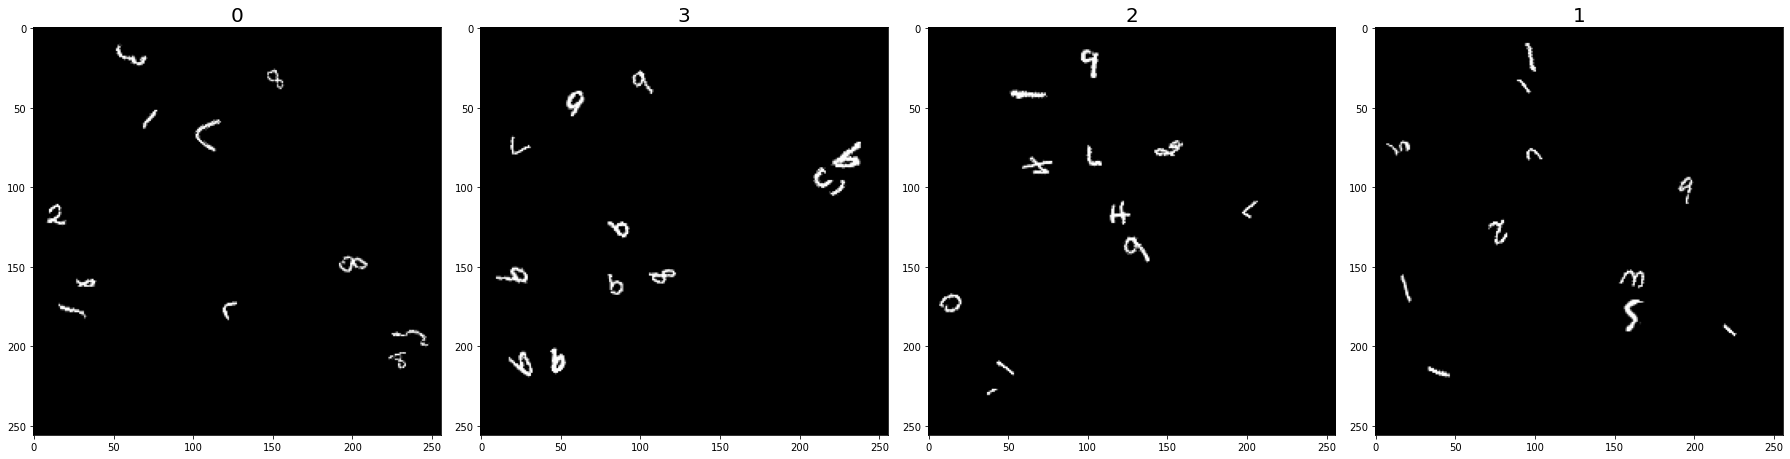

In [9]:
def show(images,labels = None):
    if labels == None:
        labels = [" "] * len(images)
    elif isinstance(labels,torch.Tensor): 
        labels = [label.item() for label in labels]
    fig, axes = plt.subplots(1, len(images), figsize=(25,25))
    for (a,image,label) in zip(axes.ravel(),images,labels):
        a.imshow(image[0].numpy(), cmap = plt.cm.gray)
        a.set_title(label, fontsize=20)

    fig.tight_layout()
show(images,labels)

# 2. Neural Network

### 2.1 Glimpse Sensor

In [10]:
def normalized_position(positions, dim):
    """ 
    Given positions `positions` [0, dim] and image dimension `dim`,
    converts them to normalized positions [-1, -1]
    
    Args:
    ----
    positions: 2D Tensor (B x 2)
    dim: Int
    """
    res = (2 * positions / float(dim)) - 1
    return torch.clamp(res,-1,1)

def inverse_normalized_position(norm_positions, dim):
    """ 
    Given normalized positions `norm_positions` [-1,-1] and image dimension `dim`,
    converts them to positions within the image [0, dim]
    
    Args:
    ----
    norm_positions: 2D Tensor (B x 2)
    dim: Int
    """
    res = (((norm_positions + 1) * float(dim)) / 2).int()
    return torch.clamp(res,0,dim)

In [11]:
class GlimpseSensor:
    """
    Extracts retina-like representations of given images.
    """
    def __init__(self, n, scale, patch_size):
        """
        Args:
        ----
        n: Int          - number of patches to extract
        patch_size: Int - size of a patch
        scale: Int      - scaling factor for each lower resolution 
        """
        self.n = n
        self.scale = scale
        self.patch_size = patch_size
    
    def extract_glimpses(self, images, location):
        """
        Extracts a retina like representation of the given images `x`, 
        centered at `location` and containing `n` resolution patches of size (`patch_size`, `patch_size`), 
        where each has a `scale` times lower resolution than the previous.
        
        Currently images of only 1 Channel (greyscale) can be processed, 
        but extension to coloured images is not hard.
        
        Args:
        ----
        x: 4D Tensor (B x C x H x W) - The image mini batch
        location: 2D Tensor (B x 2)  - normalized positions in images
        
        Returns
        -------
        4D Tensor (B x n x scale_size x scale_size ) - extracted glimpses
        """
        
        B, C, H ,W = images.shape
        l = inverse_normalized_position(location, W)
        patches = []
        for patch_index in range(self.n):
            current_scale = self.scale ** patch_index
            size = self.patch_size * current_scale
            patch = self.extract_patch(images, l , size)
            patches.append(patch)
        
        # for each patch in patches make sure size is equal to patch_size
        patches_square = []
        for patch in patches:
            size = patch.shape[-1]
            stride = int(size / self.patch_size)
            squared = F.avg_pool2d(patch, stride)
            patches_square.append(squared)
        # stack and bring in desired dimensions
        return torch.stack(patches_square).squeeze().transpose(0,1)
        
    def extract_patch(self, images, l , size):
        # shift image by half-size, effectively making centered l coordinates into top left coordinates
        # and at the same time handling out of bounds problems
        half_size = math.ceil (size / 2)
        images = F.pad(images,(half_size, half_size, half_size, half_size))
        
        # x,y tuples
        start = l
        # shifted x,y tuples
        end = start + size
        
        n_images = images.shape[0]
        patch = []
        for i in range(n_images):
            patch_i = images[i, :, start[i, 1] : end[i, 1], start[i, 0] : end[i, 0]]
            patch.append(patch_i)
        return torch.stack(patch)

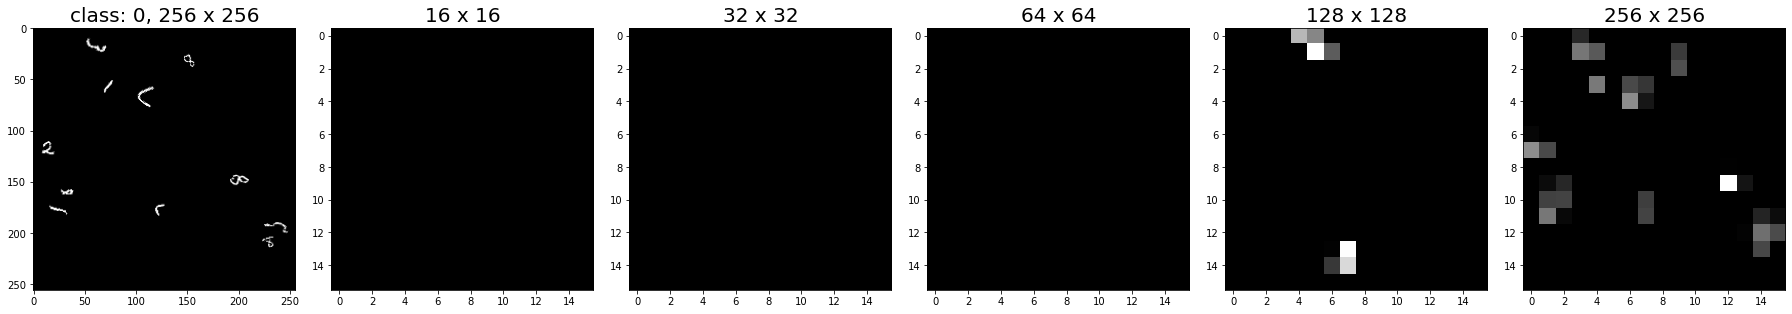

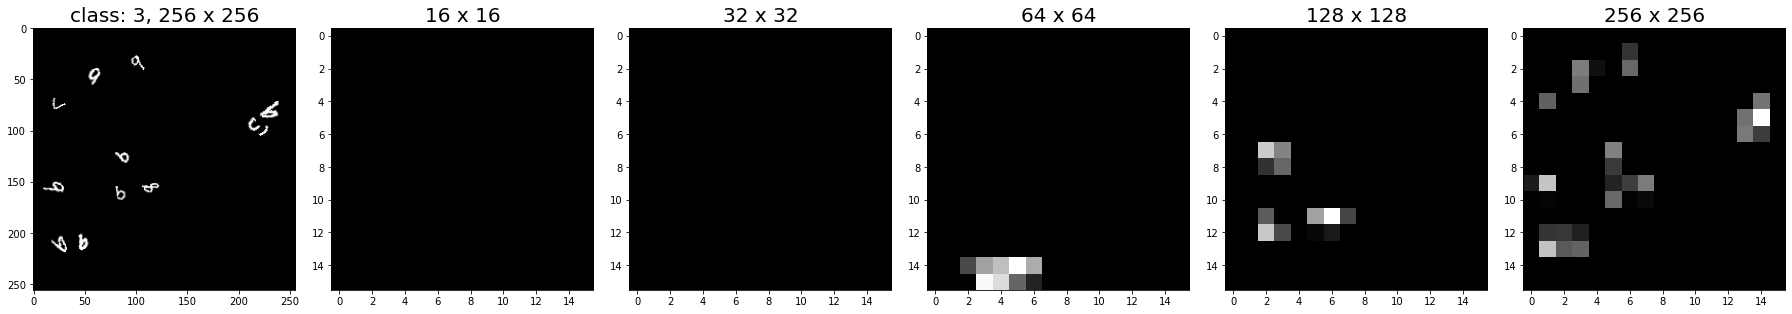

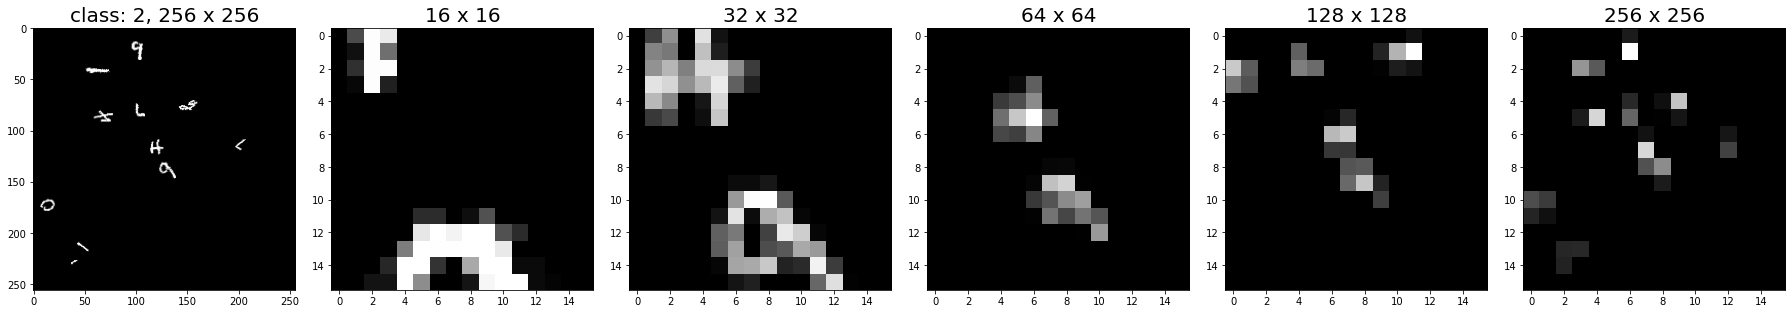

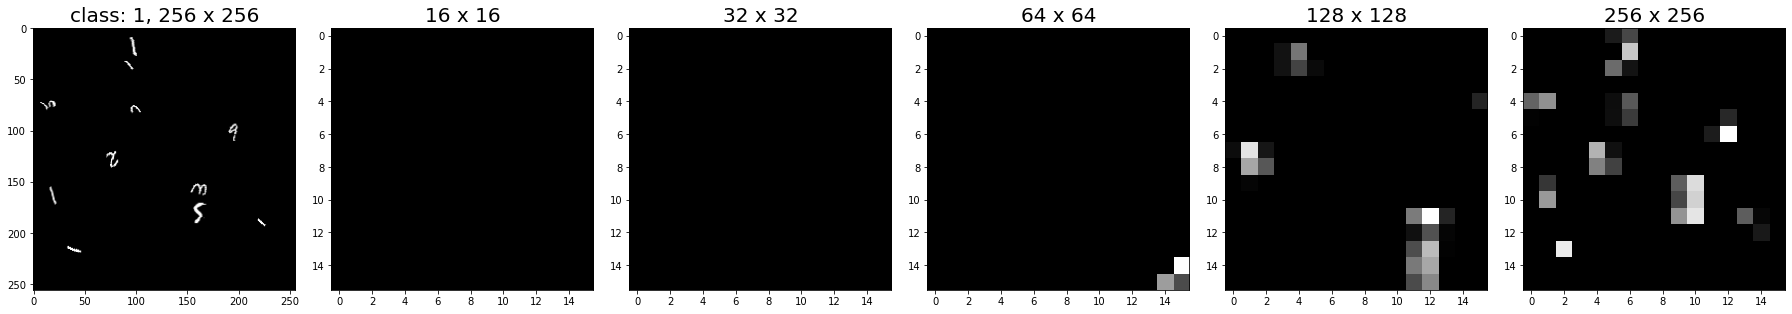

In [12]:
# plot some images by looking at the center
gs = GlimpseSensor(global_glimpse_sensor_n, global_glimpse_sensor_scale, global_glimpse_senor_patch_size)
glimpses = gs.extract_glimpses(images,torch.zeros((images.shape[0],2)))

for i in range(images.shape[0]):
    scales = [(gs.scale ** n_i) * gs.patch_size for n_i in range(gs.n)]
    l = [f"class: {labels[i].item()}, {images[i].shape[1]} x {images[i].shape[2]}"] + [f"{scale} x {scale}" for scale in scales]
    to_show = [images[i]] + [g.unsqueeze(0) for g in glimpses[i,:,:,:]]
    show(to_show,l)

### 2.2 Glimpse Network

In [13]:
class GlimpseNetwork(nn.Module):
    """
    Takes a location and encodes a `where` and `what` feature representation, which are combined together. 
    Consists of a combination of convolutional, max pooling and fully connected layers.
    """
    def __init__(self,
                 n, 
                 patch_size, 
                 scale,
                 glimpse_output_size,
                 hidden_layer_size
                ):
        """
        Args:
        ----
        n: Int                   - number of patches to extract
        patch_size: Int          - size of a patch
        scale: Int               - scaling factor for each lower resolution 
        glimpse_output_size: Int - size of output of last fully connected layer
        hidden_layer_size: Int   - size of hidden layer (number of units)
        """
        super(GlimpseNetwork, self).__init__()
        self.glimpse_sensor = GlimpseSensor(n = n, scale = scale, patch_size = patch_size)
        self.glimpse_output_size = glimpse_output_size
        self.hidden_layer_size = hidden_layer_size
                
        # what 
        
        # padding of 1, to ensure same dimensions
        self.conv1 = nn.Conv2d(in_channels = self.glimpse_sensor.n, out_channels = 16, kernel_size = 3, padding = 1)
        
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(num_features = 16, track_running_stats = True)
         
        self.max_pool1 = nn.MaxPool2d(kernel_size = 3, stride = 3, padding = 1)
        
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)

        self.max_pool2 = nn.MaxPool2d(kernel_size = 3, stride = 3, padding = 1)
        
        # TODO size in and out
        # W * H of previous layer * depth
        self.fc1 = nn.Linear(in_features = 128, out_features = self.glimpse_output_size)
        self.bn2 = nn.BatchNorm1d(num_features = self.glimpse_output_size, track_running_stats = True)
        
        # where
        # in_features = 2, loc is a tuple of (x,y)
        self.loc_fc1 = nn.Linear(in_features = 2, out_features = self.hidden_layer_size)
        self.loc_fc2 = nn.Linear(in_features = self.hidden_layer_size, out_features = self.glimpse_output_size)
        
    def forward(self, x, location):
        glimpses = self.glimpse_sensor.extract_glimpses(x, location)
        
        # what
        # 3 conv layers
        h = self.conv1(glimpses)
        h = F.relu(h)
        
        h = self.conv2(h)
        h = self.bn1(h)
        h = F.relu(h)
        
        h = self.max_pool1(h)
        
        h = F.relu(self.conv3(h))
        
        h = self.max_pool2(h) 
        
        # flatten
        # keep batch dimension and determine other one automatically
        h = h.view(x.shape[0],-1)
        
        # fully connected layers
        h = self.fc1(h)
        h = self.bn2(h)
        h = F.relu(h)
        
        # where
        l = self.loc_fc1(location)
        l = F.relu(l)
        l = self.loc_fc2(l)
        
        # combine what and where
        g = F.relu(h * l)
        return g

### 2.3 Core Network


In [14]:
class CoreNetwork(nn.Module):
    """
    Takes the `what` and `where` feature representation by the Glimpse Network
    and a hidden state to produce a new hidden state and prediction.
    Consists of 2 LSTM layers stacked on top of each other.
    """
    def __init__(self,
                 batch_size,
                 lstm_hidden_size,
                 glimpse_input_size,
                 num_layers):
        """
        Args:
        batch_size:Int          - size of a batch. Used compute the inital hidden state 
        glimpse_input_size: Int - size of the input. Equal to the output size of the Glimpse Network 
        lstm_hidden_size: Int   - size of the output and hidden layers
        num_layers: Int         - number of stacked LSTM layers
        ----
        """
        super(CoreNetwork, self).__init__()
        self.glimpse_input_size = glimpse_input_size
        self.lstm_hidden_size = lstm_hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size 
        # batch_first = false -> (SEQ x B x Features)
        self.stacked_lstm = nn.LSTM(input_size = self.glimpse_input_size,
                                    hidden_size = self.lstm_hidden_size,
                                    num_layers = self.num_layers,
                                    batch_first = False)
    
    def forward(self, x, hidden):
        # does one step 
        (prediction, new_hidden) = self.stacked_lstm(x, hidden)
        # new_hidden is a tuple of layer state and cell state 
        # remove channel dimension
        return (prediction[0], new_hidden)
        
    def initial_hidden_state(self):
        """Initialize hidden state and cell state with zeroes."""
        return (torch.zeros(self.num_layers, self.batch_size, self.lstm_hidden_size).to(global_device),
                torch.zeros(self.num_layers, self.batch_size, self.lstm_hidden_size).to(global_device))

### 2.4 Location Network

In [15]:
class LocationNetwork(nn.Module):
    """
    Takes the hidden state of the Core Network and produces a next location to attend to. 
    The next location is determined stochastically from a normal distribution 
    with a fixed deviation and a learned mean.
    
    Outputs the next location alongside the mean.
    
    Non-differentiable and needs to be trained with Reinforcment Learning.
    """
    def __init__(self,
                input_size,
                std_dev):
        """
        Args:
        ----
        input_size: Int - the input size. Equal to the output size of the Core Network
        std_dev: Float  - the fixed standard deviation/variance 
        """
        super(LocationNetwork, self).__init__()
        # location -> (x, y)
        self.fc = nn.Linear(input_size, 2)
        self.std_dev = std_dev
        
    def forward(self, h_t):
        #predicts the mean [-1,1] based on the network
        mean = torch.tanh(self.fc(h_t.detach()))
                                  
        normal_dist = Normal(mean, torch.tensor((self.std_dev,self.std_dev)).to(global_device))
        
        next_location = normal_dist.sample()
        log_probs = normal_dist.log_prob(next_location)       
        log_probs = torch.sum(log_probs, dim = 1)
        return (next_location, log_probs)            

In [16]:
class BaselineNetwork(nn.Module):
    """
    Incorporates the baseline in the reward function
    to reduce the variance of the gradient update.
    """
    def __init__(self, 
                 input_size, 
                 output_size):
        super(BaselineNetwork, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, hidden_t):
        baseline_t = F.relu(self.fc(hidden_t.detach()))
        return baseline_t

### 2.5 Action Network

In [17]:
class ActionNetwork(nn.Module):
    """
    Takes the internal state of the Core Network to produce the final output classification.
    """
    def __init__(self,
                 input_size,
                 num_classes):
        super(ActionNetwork, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)
        
    def forward(self, hidden_t_bottom_layer):
        predictions = F.log_softmax(self.fc(hidden_t_bottom_layer), dim = 1)
        return predictions

### 2.6 Deep Recurrent Attention Model


In [18]:
class DeepRecurrentAttentionModel(nn.Module):
    """
    Combines all networks described above.
    """
    def __init__(self,
                 glimpse_sensor_n = global_glimpse_sensor_n, 
                 glimpse_senor_patch_size = global_glimpse_senor_patch_size, 
                 glimpse_sensor_scale = global_glimpse_sensor_scale,
                 glimpse_network_output_size = global_glimpse_network_output_size,
                 glimpse_network_hidden_layer_size = global_glimpse_network_hidden_layer_size,
                 lstm_hidden_size = global_lstm_hidden_size,
                 lstm_num_layers = global_lstm_num_layers,
                 number_of_glimpses = global_num_glimpses,
                 batch_size = global_batch_size,
                 num_classes = global_num_classes,
                 std_dev = global_std_dev
                ):
        super(DeepRecurrentAttentionModel, self).__init__()
        self.batch_size = batch_size
        self.std_dev = std_dev
        self.number_of_glimpses = number_of_glimpses
        
        self.glimpse_network = GlimpseNetwork(n = glimpse_sensor_n,
                                              patch_size = glimpse_senor_patch_size,
                                              scale = glimpse_sensor_scale,
                                              glimpse_output_size = glimpse_network_output_size,
                                              hidden_layer_size = glimpse_network_hidden_layer_size)
        
        self.core_network = CoreNetwork(lstm_hidden_size = lstm_hidden_size,
                                       glimpse_input_size = glimpse_network_output_size,
                                       num_layers = lstm_num_layers,
                                       batch_size = batch_size)
        
        self.location_network = LocationNetwork(input_size = lstm_hidden_size, std_dev = std_dev)
        
        self.action_network = ActionNetwork(input_size = lstm_hidden_size, num_classes = num_classes)
        
        self.baseline_network = BaselineNetwork(input_size = lstm_hidden_size, output_size = 1)
    
    def initial_hidden_state(self):
        return self.core_network.initial_hidden_state()
    
    def initial_glimpse_location(self):
        return torch.Tensor(self.batch_size, 2).fill_(0.0).to(global_device)
    
    def forward(self,
                x,
                prev_hidden,
                prev_location,
                also_compute_probabilities = False):
        
        g_t = self.glimpse_network(x, prev_location.detach())
        # add seq dimension
        g_t = g_t.unsqueeze(0)
        
        # hidden_t - top layer output
        # total_hidden_t - all layers including cell parameters
        (hidden_t, total_hidden_t) = self.core_network(g_t, prev_hidden)
        
        (location_t, location_mean_t) = self.location_network(hidden_t.detach())
        baseline_t = self.baseline_network(hidden_t.detach())
        
        if also_compute_probabilities:
            # takes not the top, but the bottom layer in the paper
            probs_t = self.action_network(total_hidden_t[0][0])
            return (total_hidden_t, location_t, location_mean_t, baseline_t, probs_t)
        else:
            return (total_hidden_t, location_t, location_mean_t, baseline_t)

## 3. Train

In [19]:
class RunningAverage(object):
    """Computes a running average."""
    def __init__(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def add(self, val, n = 1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [20]:
class Train:
    """
    Entry class, takes care of training, checkpoints and output.
    """
    def __init__(self,
                 train_loader,
                 valid_loader,
                 test_loader,
                 model_name = global_model_name, 
                 learning_rate = global_learning_rate,
                 num_epochs = global_num_epochs,
                 batch_size = global_batch_size,
                 num_glimpses = global_num_glimpses,
                 checkpoint_dir = "./models",
                 model_patience = global_model_patience ,
                 resume = True
                 ):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.num_glimpses = num_glimpses
        self.batch_size = batch_size
        self.model_name = model_name
        self.checkpoint_dir = checkpoint_dir
        self.best_valid_acc = 0
        self.start_epoch = 0
        self.resume = resume
        self.model_patience = model_patience
        self.current_without_improvement = 0
        
        # Device configuration
        self.device = global_device
        
        # loaders
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader

        self.num_train = len(train_loader.dataset)
        self.num_valid = len(valid_loader.dataset)
        self.num_test = len(test_loader.dataset)
        
        self.model = DeepRecurrentAttentionModel().to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.learning_rate)
        self.MSELoss = nn.MSELoss()
        self.NLLLoss = nn.NLLLoss()
        
    def train(self):
        if self.resume:
            self.load_checkpoint(load_best = False)
        for epoch in range(self.start_epoch, self.num_epochs):
            # switch layers to train mode
            self.model.train()
            # train for 1 epoch
            train_loss, train_acc = self.train_single_epoch()            
            print("Epoch: {}, avg. loss: {:3.3f}, avg. acc: {:3.3f}".format((epoch), train_loss, train_acc))
            
            # evaluate on validation set
            valid_loss, valid_acc = self.evaluate(is_test = False, epoch = epoch)

            # update best
            is_best = valid_acc >  self.best_valid_acc
            if is_best:
                self.current_without_improvement = 0
            else:
                self.current_without_improvement += 1
            self.best_valid_acc = max(valid_acc, self.best_valid_acc)
            
            # checkpoint
            self.save_checkpoint(
                {'epoch': epoch + 1,
                 'model_state': self.model.state_dict(),
                 'optim_state': self.optimizer.state_dict(),
                 'best_valid_acc': self.best_valid_acc,
                 },is_best
            )
            if self.current_without_improvement > self.model_patience:
                print(f"{self.model_patience} epochs without improvement. Stopping.")
                return
    
    def forward_pass(self, images, labels):
        hidden_t = self.model.initial_hidden_state()
        location_t = self.model.initial_glimpse_location()
        baselines = []
        log_probs = []
        for glimpse_i in range(self.num_glimpses):
            is_last = glimpse_i == self.num_glimpses - 1
            if is_last :
                (hidden_t, location_t, log_probs_t, baseline_t, probs_t) = self.model(images,
                                                                                  hidden_t,
                                                                                  location_t, 
                                                                                  also_compute_probabilities = True)
            else:
                (hidden_t, location_t, log_probs_t, baseline_t) = self.model(images, hidden_t, location_t)
            baselines.append(baseline_t[:,0])
            
            log_probs.append(log_probs_t)
 
        baselines = torch.stack(baselines).transpose(1, 0)
        log_probs = torch.stack(log_probs).transpose(1, 0)
         
        # compute loss and rewards

        # reward
        predicted = probs_t.argmax(dim = 1).detach()
        rewards = (predicted == labels).float()

        rewards = rewards.unsqueeze(1).repeat(1, self.num_glimpses)

        # losses 
        # action
        loss_action = self.NLLLoss(probs_t, labels)

        # baseline
        loss_baseline = self.MSELoss(baselines, rewards)

        # reinforcement
        adjusted_reward = rewards - baselines.detach()
        
        #minus because the higher the reward: the better
        log_likelihood_rewards = torch.sum( - log_probs * adjusted_reward, dim = 1)
        loss_reinforce = torch.mean(log_likelihood_rewards, dim = 0)

        loss = loss_action + loss_baseline + loss_reinforce
        
        #if np.random.randint(1,51,1).item() == 50:
        #    print(f"Loss = [A:{loss_action:+7.3},B:{loss_baseline:+7.3},R:{loss_reinforce:+7.3}] - Weight sum = [A:{self.model.action_network.fc.weight.detach().sum():+7.3},B:{self.model.baseline_network.fc.weight.detach().sum():+7.3},R:{self.model.location_network.fc.weight.detach().sum():+7.3}]")
        
        return (predicted, loss)
    
    def train_single_epoch(self):
        epoch_losses = RunningAverage()
        epoch_accuracies = RunningAverage()
        
        with tqdm(total = self.num_train) as pbar:
            start = time.time()
            # images - mini batch
            for i, (images, labels) in enumerate(self.train_loader): 
                images = images.to(self.device)
                labels = labels.to(self.device)
                # forward pass
                (predictions,loss) = self.forward_pass(images, labels)
                # backward and optimize
                #print(self.model.action_network.fc.weight.grad)
                # zero out current gradiate accumulators
                self.optimizer.zero_grad()
                # propagate new ones
                loss.backward()
                
                #print(self.model.baseline_network.fc.weight.grad)    
                self.optimizer.step()
                
                # compute accuracy
                correct = (predictions == labels).float()
                acc = 100 * (correct.sum() / len(labels))
                
                elapsed = time.time() - start
                # store
                epoch_losses.add(loss.item(), len(images))
                epoch_accuracies.add(acc.item(), len(images))
                
                pbar.set_description(("{:.1f}s loss: {:.3f} , acc: {:3.3f}"
                                      .format(elapsed, loss.item(), acc.item())))
                pbar.update(self.batch_size)
        return (epoch_losses.avg, epoch_accuracies.avg)
        
    def evaluate(self, is_test, epoch = None, runs = 1):
        loader = self.test_loader if is_test else self.valid_loader
        name = "test" if is_test else f"Epoch: {epoch}, validation"
        
        n = self.num_test if is_test else self.num_valid
        if is_test:
            self.load_checkpoint(load_best = True)
        
        # switch layers to evaluation mode    
        self.model.eval()
        
        correct = 0
        losses = RunningAverage()
        
        with torch.no_grad():
            correct_total = []
            losses_total = []
            for i in range(runs):
                correct = 0
                losses = RunningAverage()
                #with tqdm(total = self.num_train) as pbar:
                start = time.time()
                # images - mini batch
                for i, (images, labels) in enumerate(loader):
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    # forward pass
                    (predictions, loss) = self.forward_pass(images, labels)

                    # compute accuracy
                    correct += (predictions == labels).int().sum().item()
                    losses.add(loss.item(), len(images))
                    elapsed = time.time() - start

                    # store
                    losses.add(loss.item(), len(images))

                    #pbar.set_description(("{:.1f}s Evaluating... ".format(elapsed)))
                    #pbar.update(self.batch_size)
                correct_total.append(correct)
                losses_total.append(losses.avg)
            
            correct = int(mean(correct_total))
            loss = mean(losses_total)
            accuracy = (100. * correct) / n
        print(f'[*] {name} - {correct}/{n} Correct, Acc: ({accuracy:3.2f}%), Err({(100-accuracy):3.2f}%)')
        return (loss, accuracy)
    
    def save_checkpoint(self, state, is_best):
        filename = self.model_name + '_ckpt'
        ckpt_path = os.path.join(self.checkpoint_dir, filename)
        os.makedirs(self.checkpoint_dir,exist_ok = True)
        torch.save(state, ckpt_path)
                    
        if is_best:
            filename = self.model_name + '_model_best'
            shutil.copyfile(ckpt_path, os.path.join(self.checkpoint_dir, filename))

    def load_checkpoint(self, load_best):
        print("[*] Loading model from {}".format(self.checkpoint_dir))

        filename = self.model_name + '_ckpt'
        if load_best:
            filename = self.model_name + '_model_best'
        ckpt_path = os.path.join(self.checkpoint_dir, filename)
        if  not os.path.exists(ckpt_path):
            print("No checkpoint found, starting from scratch")
            return
        
        ckpt = torch.load(ckpt_path) if torch.cuda.is_available() else torch.load(ckpt_path,map_location=torch.device('cpu'))

        # load variables from checkpoint
        self.best_valid_acc = ckpt['best_valid_acc']
        #self.start_epoch = ckpt['epoch']
        self.model.load_state_dict(ckpt['model_state'])
        self.optimizer.load_state_dict(ckpt['optim_state'])

        if load_best:
            print(
                "[*] Loaded {} checkpoint @ epoch {} "
                "with best valid acc of {:.3f}".format(
                    filename, ckpt['epoch'], ckpt['best_valid_acc'])
            )
        else:
            print(
                "[*] Loaded {} checkpoint @ epoch {}".format(
                    filename, ckpt['epoch'])
            )

In [21]:
mnist_train_data = dataset()
mnist_train_length = int(len(mnist_train_data) * 0.9)
mnist_valid_length = len(mnist_train_data) - mnist_train_length

(mnist_train, mnist_valid) = torch.utils.data.random_split(mnist_train_data,(mnist_train_length, mnist_valid_length))
mnist_test = dataset(train = False)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size = global_batch_size,
                                          shuffle = True, num_workers = 0)

valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size = global_batch_size,
                                          shuffle = False, num_workers = 0)

test_loader = torch.utils.data.DataLoader(mnist_valid, batch_size = global_batch_size,
                                          shuffle = False, num_workers = 0)

trainer = Train(train_loader = train_loader,
      valid_loader = valid_loader,
      test_loader = test_loader)

Data existing, skipping creation.


Data existing, skipping creation.


### 3.1 Plot backward graph

### 3.2 Start training

In [22]:
trainer.train()

[*] Loading model from ./models
No checkpoint found, starting from scratch



Epoch: 0, avg. loss: 1.456, avg. acc: 24.683


[*] Epoch: 0, validation - 496/2000 Correct, Acc: (24.80%), Err(75.20%)



Epoch: 1, avg. loss: 1.561, avg. acc: 26.722


[*] Epoch: 1, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 2, avg. loss: 1.558, avg. acc: 30.083


[*] Epoch: 2, validation - 600/2000 Correct, Acc: (30.00%), Err(70.00%)



Epoch: 3, avg. loss: 1.547, avg. acc: 31.878


[*] Epoch: 3, validation - 669/2000 Correct, Acc: (33.45%), Err(66.55%)



Epoch: 4, avg. loss: 1.572, avg. acc: 32.800


[*] Epoch: 4, validation - 655/2000 Correct, Acc: (32.75%), Err(67.25%)



Epoch: 5, avg. loss: 1.551, avg. acc: 32.694


[*] Epoch: 5, validation - 646/2000 Correct, Acc: (32.30%), Err(67.70%)



Epoch: 6, avg. loss: 1.557, avg. acc: 33.194


[*] Epoch: 6, validation - 633/2000 Correct, Acc: (31.65%), Err(68.35%)



Epoch: 7, avg. loss: 1.550, avg. acc: 33.511


[*] Epoch: 7, validation - 653/2000 Correct, Acc: (32.65%), Err(67.35%)



Epoch: 8, avg. loss: 1.558, avg. acc: 33.572


[*] Epoch: 8, validation - 661/2000 Correct, Acc: (33.05%), Err(66.95%)



Epoch: 9, avg. loss: 1.553, avg. acc: 33.794


[*] Epoch: 9, validation - 668/2000 Correct, Acc: (33.40%), Err(66.60%)



Epoch: 10, avg. loss: 1.559, avg. acc: 33.806


[*] Epoch: 10, validation - 699/2000 Correct, Acc: (34.95%), Err(65.05%)



Epoch: 11, avg. loss: 1.544, avg. acc: 33.661


[*] Epoch: 11, validation - 680/2000 Correct, Acc: (34.00%), Err(66.00%)



Epoch: 12, avg. loss: 1.543, avg. acc: 33.733


[*] Epoch: 12, validation - 678/2000 Correct, Acc: (33.90%), Err(66.10%)



Epoch: 13, avg. loss: 1.537, avg. acc: 34.439


[*] Epoch: 13, validation - 673/2000 Correct, Acc: (33.65%), Err(66.35%)



Epoch: 14, avg. loss: 1.542, avg. acc: 34.339


[*] Epoch: 14, validation - 657/2000 Correct, Acc: (32.85%), Err(67.15%)



Epoch: 15, avg. loss: 1.556, avg. acc: 34.478


[*] Epoch: 15, validation - 678/2000 Correct, Acc: (33.90%), Err(66.10%)



Epoch: 16, avg. loss: 1.549, avg. acc: 34.983


[*] Epoch: 16, validation - 672/2000 Correct, Acc: (33.60%), Err(66.40%)



Epoch: 17, avg. loss: 1.564, avg. acc: 35.117


[*] Epoch: 17, validation - 667/2000 Correct, Acc: (33.35%), Err(66.65%)



Epoch: 18, avg. loss: 1.535, avg. acc: 34.867


[*] Epoch: 18, validation - 669/2000 Correct, Acc: (33.45%), Err(66.55%)



Epoch: 19, avg. loss: 1.515, avg. acc: 35.372


[*] Epoch: 19, validation - 667/2000 Correct, Acc: (33.35%), Err(66.65%)



Epoch: 20, avg. loss: 1.530, avg. acc: 35.872


[*] Epoch: 20, validation - 686/2000 Correct, Acc: (34.30%), Err(65.70%)



Epoch: 21, avg. loss: 1.519, avg. acc: 36.606


[*] Epoch: 21, validation - 663/2000 Correct, Acc: (33.15%), Err(66.85%)



Epoch: 22, avg. loss: 1.511, avg. acc: 36.889


[*] Epoch: 22, validation - 662/2000 Correct, Acc: (33.10%), Err(66.90%)



Epoch: 23, avg. loss: 1.496, avg. acc: 37.494


[*] Epoch: 23, validation - 667/2000 Correct, Acc: (33.35%), Err(66.65%)



Epoch: 24, avg. loss: 1.495, avg. acc: 37.722


[*] Epoch: 24, validation - 641/2000 Correct, Acc: (32.05%), Err(67.95%)



Epoch: 25, avg. loss: 1.496, avg. acc: 38.761


[*] Epoch: 25, validation - 680/2000 Correct, Acc: (34.00%), Err(66.00%)



Epoch: 26, avg. loss: 1.494, avg. acc: 39.428


[*] Epoch: 26, validation - 636/2000 Correct, Acc: (31.80%), Err(68.20%)



Epoch: 27, avg. loss: 1.460, avg. acc: 39.861


[*] Epoch: 27, validation - 638/2000 Correct, Acc: (31.90%), Err(68.10%)



Epoch: 28, avg. loss: 1.434, avg. acc: 40.011


[*] Epoch: 28, validation - 673/2000 Correct, Acc: (33.65%), Err(66.35%)



Epoch: 29, avg. loss: 1.462, avg. acc: 40.972


[*] Epoch: 29, validation - 648/2000 Correct, Acc: (32.40%), Err(67.60%)



Epoch: 30, avg. loss: 1.440, avg. acc: 41.106


[*] Epoch: 30, validation - 644/2000 Correct, Acc: (32.20%), Err(67.80%)



Epoch: 31, avg. loss: 1.420, avg. acc: 41.356


[*] Epoch: 31, validation - 638/2000 Correct, Acc: (31.90%), Err(68.10%)



Epoch: 32, avg. loss: 1.417, avg. acc: 41.833


[*] Epoch: 32, validation - 602/2000 Correct, Acc: (30.10%), Err(69.90%)



Epoch: 33, avg. loss: 1.435, avg. acc: 42.361


[*] Epoch: 33, validation - 607/2000 Correct, Acc: (30.35%), Err(69.65%)



Epoch: 34, avg. loss: 1.408, avg. acc: 42.417


[*] Epoch: 34, validation - 600/2000 Correct, Acc: (30.00%), Err(70.00%)



Epoch: 35, avg. loss: 1.396, avg. acc: 42.672


[*] Epoch: 35, validation - 614/2000 Correct, Acc: (30.70%), Err(69.30%)



Epoch: 36, avg. loss: 1.399, avg. acc: 43.172


[*] Epoch: 36, validation - 621/2000 Correct, Acc: (31.05%), Err(68.95%)



Epoch: 37, avg. loss: 1.401, avg. acc: 43.467


[*] Epoch: 37, validation - 615/2000 Correct, Acc: (30.75%), Err(69.25%)



Epoch: 38, avg. loss: 1.399, avg. acc: 43.672


[*] Epoch: 38, validation - 617/2000 Correct, Acc: (30.85%), Err(69.15%)



Epoch: 39, avg. loss: 1.352, avg. acc: 43.472


[*] Epoch: 39, validation - 611/2000 Correct, Acc: (30.55%), Err(69.45%)



Epoch: 40, avg. loss: 1.385, avg. acc: 43.489


[*] Epoch: 40, validation - 615/2000 Correct, Acc: (30.75%), Err(69.25%)



Epoch: 41, avg. loss: 1.384, avg. acc: 44.389


[*] Epoch: 41, validation - 613/2000 Correct, Acc: (30.65%), Err(69.35%)



Epoch: 42, avg. loss: 1.341, avg. acc: 44.528


[*] Epoch: 42, validation - 606/2000 Correct, Acc: (30.30%), Err(69.70%)



Epoch: 43, avg. loss: 1.347, avg. acc: 45.056


[*] Epoch: 43, validation - 632/2000 Correct, Acc: (31.60%), Err(68.40%)



Epoch: 44, avg. loss: 1.355, avg. acc: 44.861


[*] Epoch: 44, validation - 618/2000 Correct, Acc: (30.90%), Err(69.10%)



Epoch: 45, avg. loss: 1.339, avg. acc: 45.517


[*] Epoch: 45, validation - 584/2000 Correct, Acc: (29.20%), Err(70.80%)



Epoch: 46, avg. loss: 1.339, avg. acc: 45.644


[*] Epoch: 46, validation - 592/2000 Correct, Acc: (29.60%), Err(70.40%)



Epoch: 47, avg. loss: 1.338, avg. acc: 46.156


[*] Epoch: 47, validation - 577/2000 Correct, Acc: (28.85%), Err(71.15%)



Epoch: 48, avg. loss: 1.329, avg. acc: 45.922


[*] Epoch: 48, validation - 595/2000 Correct, Acc: (29.75%), Err(70.25%)



Epoch: 49, avg. loss: 1.338, avg. acc: 45.917


[*] Epoch: 49, validation - 611/2000 Correct, Acc: (30.55%), Err(69.45%)



Epoch: 50, avg. loss: 1.330, avg. acc: 46.761


[*] Epoch: 50, validation - 580/2000 Correct, Acc: (29.00%), Err(71.00%)



Epoch: 51, avg. loss: 1.334, avg. acc: 47.106


[*] Epoch: 51, validation - 591/2000 Correct, Acc: (29.55%), Err(70.45%)



Epoch: 52, avg. loss: 1.303, avg. acc: 47.478


[*] Epoch: 52, validation - 607/2000 Correct, Acc: (30.35%), Err(69.65%)



Epoch: 53, avg. loss: 1.326, avg. acc: 46.739


[*] Epoch: 53, validation - 581/2000 Correct, Acc: (29.05%), Err(70.95%)



Epoch: 54, avg. loss: 1.286, avg. acc: 46.972


[*] Epoch: 54, validation - 575/2000 Correct, Acc: (28.75%), Err(71.25%)



Epoch: 55, avg. loss: 1.285, avg. acc: 47.844


[*] Epoch: 55, validation - 573/2000 Correct, Acc: (28.65%), Err(71.35%)



Epoch: 56, avg. loss: 1.295, avg. acc: 48.017


[*] Epoch: 56, validation - 590/2000 Correct, Acc: (29.50%), Err(70.50%)



Epoch: 57, avg. loss: 1.280, avg. acc: 48.156


[*] Epoch: 57, validation - 612/2000 Correct, Acc: (30.60%), Err(69.40%)



Epoch: 58, avg. loss: 1.297, avg. acc: 48.778


[*] Epoch: 58, validation - 590/2000 Correct, Acc: (29.50%), Err(70.50%)



Epoch: 59, avg. loss: 1.270, avg. acc: 49.056


[*] Epoch: 59, validation - 572/2000 Correct, Acc: (28.60%), Err(71.40%)



Epoch: 60, avg. loss: 1.263, avg. acc: 49.478


[*] Epoch: 60, validation - 568/2000 Correct, Acc: (28.40%), Err(71.60%)



Epoch: 61, avg. loss: 1.260, avg. acc: 49.444


[*] Epoch: 61, validation - 601/2000 Correct, Acc: (30.05%), Err(69.95%)



Epoch: 62, avg. loss: 1.273, avg. acc: 49.589


[*] Epoch: 62, validation - 585/2000 Correct, Acc: (29.25%), Err(70.75%)



Epoch: 63, avg. loss: 1.272, avg. acc: 50.083


[*] Epoch: 63, validation - 602/2000 Correct, Acc: (30.10%), Err(69.90%)



Epoch: 64, avg. loss: 1.265, avg. acc: 49.778


[*] Epoch: 64, validation - 578/2000 Correct, Acc: (28.90%), Err(71.10%)



Epoch: 65, avg. loss: 1.261, avg. acc: 50.178


[*] Epoch: 65, validation - 583/2000 Correct, Acc: (29.15%), Err(70.85%)



Epoch: 66, avg. loss: 1.274, avg. acc: 51.189


[*] Epoch: 66, validation - 558/2000 Correct, Acc: (27.90%), Err(72.10%)



Epoch: 67, avg. loss: 1.249, avg. acc: 50.028


[*] Epoch: 67, validation - 591/2000 Correct, Acc: (29.55%), Err(70.45%)



Epoch: 68, avg. loss: 1.255, avg. acc: 50.506


[*] Epoch: 68, validation - 570/2000 Correct, Acc: (28.50%), Err(71.50%)



Epoch: 69, avg. loss: 1.250, avg. acc: 51.239


[*] Epoch: 69, validation - 572/2000 Correct, Acc: (28.60%), Err(71.40%)



Epoch: 70, avg. loss: 1.248, avg. acc: 50.678


[*] Epoch: 70, validation - 590/2000 Correct, Acc: (29.50%), Err(70.50%)



Epoch: 71, avg. loss: 1.246, avg. acc: 51.228


[*] Epoch: 71, validation - 578/2000 Correct, Acc: (28.90%), Err(71.10%)



Epoch: 72, avg. loss: 1.245, avg. acc: 51.239


[*] Epoch: 72, validation - 586/2000 Correct, Acc: (29.30%), Err(70.70%)



Epoch: 73, avg. loss: 1.217, avg. acc: 51.222


[*] Epoch: 73, validation - 585/2000 Correct, Acc: (29.25%), Err(70.75%)



Epoch: 74, avg. loss: 1.225, avg. acc: 51.717


[*] Epoch: 74, validation - 598/2000 Correct, Acc: (29.90%), Err(70.10%)



Epoch: 75, avg. loss: 1.231, avg. acc: 52.428


[*] Epoch: 75, validation - 582/2000 Correct, Acc: (29.10%), Err(70.90%)



Epoch: 76, avg. loss: 1.213, avg. acc: 51.944


[*] Epoch: 76, validation - 592/2000 Correct, Acc: (29.60%), Err(70.40%)



Epoch: 77, avg. loss: 1.220, avg. acc: 52.533


[*] Epoch: 77, validation - 598/2000 Correct, Acc: (29.90%), Err(70.10%)



Epoch: 78, avg. loss: 1.202, avg. acc: 52.656


[*] Epoch: 78, validation - 571/2000 Correct, Acc: (28.55%), Err(71.45%)



Epoch: 79, avg. loss: 1.200, avg. acc: 52.761


[*] Epoch: 79, validation - 588/2000 Correct, Acc: (29.40%), Err(70.60%)



Epoch: 80, avg. loss: 1.222, avg. acc: 52.856


[*] Epoch: 80, validation - 604/2000 Correct, Acc: (30.20%), Err(69.80%)



Epoch: 81, avg. loss: 1.196, avg. acc: 53.244


[*] Epoch: 81, validation - 593/2000 Correct, Acc: (29.65%), Err(70.35%)



Epoch: 82, avg. loss: 1.185, avg. acc: 53.639


[*] Epoch: 82, validation - 584/2000 Correct, Acc: (29.20%), Err(70.80%)



Epoch: 83, avg. loss: 1.202, avg. acc: 53.261


[*] Epoch: 83, validation - 594/2000 Correct, Acc: (29.70%), Err(70.30%)



Epoch: 84, avg. loss: 1.183, avg. acc: 53.828


[*] Epoch: 84, validation - 613/2000 Correct, Acc: (30.65%), Err(69.35%)



Epoch: 85, avg. loss: 1.205, avg. acc: 53.533


[*] Epoch: 85, validation - 595/2000 Correct, Acc: (29.75%), Err(70.25%)



Epoch: 86, avg. loss: 1.194, avg. acc: 54.794


[*] Epoch: 86, validation - 581/2000 Correct, Acc: (29.05%), Err(70.95%)



Epoch: 87, avg. loss: 1.179, avg. acc: 54.561


[*] Epoch: 87, validation - 582/2000 Correct, Acc: (29.10%), Err(70.90%)



Epoch: 88, avg. loss: 1.183, avg. acc: 54.850


[*] Epoch: 88, validation - 589/2000 Correct, Acc: (29.45%), Err(70.55%)



Epoch: 89, avg. loss: 1.184, avg. acc: 54.622


[*] Epoch: 89, validation - 607/2000 Correct, Acc: (30.35%), Err(69.65%)



Epoch: 90, avg. loss: 1.175, avg. acc: 54.828


[*] Epoch: 90, validation - 591/2000 Correct, Acc: (29.55%), Err(70.45%)



Epoch: 91, avg. loss: 1.169, avg. acc: 55.439


[*] Epoch: 91, validation - 623/2000 Correct, Acc: (31.15%), Err(68.85%)



Epoch: 92, avg. loss: 1.153, avg. acc: 55.267


[*] Epoch: 92, validation - 576/2000 Correct, Acc: (28.80%), Err(71.20%)



Epoch: 93, avg. loss: 1.153, avg. acc: 55.617


[*] Epoch: 93, validation - 586/2000 Correct, Acc: (29.30%), Err(70.70%)



Epoch: 94, avg. loss: 1.162, avg. acc: 56.228


[*] Epoch: 94, validation - 605/2000 Correct, Acc: (30.25%), Err(69.75%)



Epoch: 95, avg. loss: 1.160, avg. acc: 55.628


[*] Epoch: 95, validation - 590/2000 Correct, Acc: (29.50%), Err(70.50%)



Epoch: 96, avg. loss: 1.169, avg. acc: 56.139


[*] Epoch: 96, validation - 627/2000 Correct, Acc: (31.35%), Err(68.65%)



Epoch: 97, avg. loss: 1.168, avg. acc: 56.656


[*] Epoch: 97, validation - 599/2000 Correct, Acc: (29.95%), Err(70.05%)



Epoch: 98, avg. loss: 1.153, avg. acc: 57.022


[*] Epoch: 98, validation - 572/2000 Correct, Acc: (28.60%), Err(71.40%)



Epoch: 99, avg. loss: 1.156, avg. acc: 56.139


[*] Epoch: 99, validation - 591/2000 Correct, Acc: (29.55%), Err(70.45%)



Epoch: 100, avg. loss: 1.137, avg. acc: 57.228


[*] Epoch: 100, validation - 584/2000 Correct, Acc: (29.20%), Err(70.80%)



Epoch: 101, avg. loss: 1.139, avg. acc: 56.778


[*] Epoch: 101, validation - 595/2000 Correct, Acc: (29.75%), Err(70.25%)



Epoch: 102, avg. loss: 1.147, avg. acc: 57.144


[*] Epoch: 102, validation - 589/2000 Correct, Acc: (29.45%), Err(70.55%)



Epoch: 103, avg. loss: 1.118, avg. acc: 58.033


[*] Epoch: 103, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 104, avg. loss: 1.136, avg. acc: 57.750


[*] Epoch: 104, validation - 577/2000 Correct, Acc: (28.85%), Err(71.15%)



Epoch: 105, avg. loss: 1.138, avg. acc: 58.083


[*] Epoch: 105, validation - 594/2000 Correct, Acc: (29.70%), Err(70.30%)



Epoch: 106, avg. loss: 1.087, avg. acc: 58.161


[*] Epoch: 106, validation - 591/2000 Correct, Acc: (29.55%), Err(70.45%)



Epoch: 107, avg. loss: 1.132, avg. acc: 58.244


[*] Epoch: 107, validation - 604/2000 Correct, Acc: (30.20%), Err(69.80%)



Epoch: 108, avg. loss: 1.128, avg. acc: 58.178


[*] Epoch: 108, validation - 598/2000 Correct, Acc: (29.90%), Err(70.10%)



Epoch: 109, avg. loss: 1.090, avg. acc: 59.550


[*] Epoch: 109, validation - 589/2000 Correct, Acc: (29.45%), Err(70.55%)



Epoch: 110, avg. loss: 1.127, avg. acc: 58.961


[*] Epoch: 110, validation - 587/2000 Correct, Acc: (29.35%), Err(70.65%)



Epoch: 111, avg. loss: 1.096, avg. acc: 59.383


[*] Epoch: 111, validation - 604/2000 Correct, Acc: (30.20%), Err(69.80%)



Epoch: 112, avg. loss: 1.090, avg. acc: 59.144


[*] Epoch: 112, validation - 582/2000 Correct, Acc: (29.10%), Err(70.90%)



Epoch: 113, avg. loss: 1.108, avg. acc: 59.333


[*] Epoch: 113, validation - 587/2000 Correct, Acc: (29.35%), Err(70.65%)



Epoch: 114, avg. loss: 1.095, avg. acc: 59.467


[*] Epoch: 114, validation - 576/2000 Correct, Acc: (28.80%), Err(71.20%)



Epoch: 115, avg. loss: 1.091, avg. acc: 59.756


[*] Epoch: 115, validation - 607/2000 Correct, Acc: (30.35%), Err(69.65%)



Epoch: 116, avg. loss: 1.108, avg. acc: 59.878


[*] Epoch: 116, validation - 587/2000 Correct, Acc: (29.35%), Err(70.65%)



Epoch: 117, avg. loss: 1.077, avg. acc: 60.200


[*] Epoch: 117, validation - 585/2000 Correct, Acc: (29.25%), Err(70.75%)



Epoch: 118, avg. loss: 1.071, avg. acc: 60.689


[*] Epoch: 118, validation - 596/2000 Correct, Acc: (29.80%), Err(70.20%)



Epoch: 119, avg. loss: 1.098, avg. acc: 60.456


[*] Epoch: 119, validation - 594/2000 Correct, Acc: (29.70%), Err(70.30%)



Epoch: 120, avg. loss: 1.076, avg. acc: 60.650


[*] Epoch: 120, validation - 572/2000 Correct, Acc: (28.60%), Err(71.40%)



Epoch: 121, avg. loss: 1.068, avg. acc: 61.233


[*] Epoch: 121, validation - 573/2000 Correct, Acc: (28.65%), Err(71.35%)



Epoch: 122, avg. loss: 1.062, avg. acc: 60.828


[*] Epoch: 122, validation - 577/2000 Correct, Acc: (28.85%), Err(71.15%)



Epoch: 123, avg. loss: 1.069, avg. acc: 61.583


[*] Epoch: 123, validation - 582/2000 Correct, Acc: (29.10%), Err(70.90%)



Epoch: 124, avg. loss: 1.051, avg. acc: 61.467


[*] Epoch: 124, validation - 587/2000 Correct, Acc: (29.35%), Err(70.65%)



Epoch: 125, avg. loss: 1.063, avg. acc: 61.494


[*] Epoch: 125, validation - 571/2000 Correct, Acc: (28.55%), Err(71.45%)



Epoch: 126, avg. loss: 1.064, avg. acc: 61.872


[*] Epoch: 126, validation - 570/2000 Correct, Acc: (28.50%), Err(71.50%)



Epoch: 127, avg. loss: 1.071, avg. acc: 62.083


[*] Epoch: 127, validation - 561/2000 Correct, Acc: (28.05%), Err(71.95%)



Epoch: 128, avg. loss: 1.062, avg. acc: 62.233


[*] Epoch: 128, validation - 582/2000 Correct, Acc: (29.10%), Err(70.90%)



Epoch: 129, avg. loss: 1.033, avg. acc: 62.644


[*] Epoch: 129, validation - 574/2000 Correct, Acc: (28.70%), Err(71.30%)



Epoch: 130, avg. loss: 1.062, avg. acc: 62.494


[*] Epoch: 130, validation - 582/2000 Correct, Acc: (29.10%), Err(70.90%)



Epoch: 131, avg. loss: 1.043, avg. acc: 62.700


[*] Epoch: 131, validation - 572/2000 Correct, Acc: (28.60%), Err(71.40%)



Epoch: 132, avg. loss: 1.045, avg. acc: 62.761


[*] Epoch: 132, validation - 572/2000 Correct, Acc: (28.60%), Err(71.40%)



Epoch: 133, avg. loss: 1.032, avg. acc: 63.283


[*] Epoch: 133, validation - 558/2000 Correct, Acc: (27.90%), Err(72.10%)



Epoch: 134, avg. loss: 1.008, avg. acc: 63.383


[*] Epoch: 134, validation - 582/2000 Correct, Acc: (29.10%), Err(70.90%)



Epoch: 135, avg. loss: 1.052, avg. acc: 63.439


[*] Epoch: 135, validation - 563/2000 Correct, Acc: (28.15%), Err(71.85%)



Epoch: 136, avg. loss: 1.029, avg. acc: 63.578


[*] Epoch: 136, validation - 557/2000 Correct, Acc: (27.85%), Err(72.15%)



Epoch: 137, avg. loss: 1.019, avg. acc: 63.811


[*] Epoch: 137, validation - 557/2000 Correct, Acc: (27.85%), Err(72.15%)



Epoch: 138, avg. loss: 1.023, avg. acc: 64.428


[*] Epoch: 138, validation - 568/2000 Correct, Acc: (28.40%), Err(71.60%)



Epoch: 139, avg. loss: 0.999, avg. acc: 64.067


[*] Epoch: 139, validation - 555/2000 Correct, Acc: (27.75%), Err(72.25%)



Epoch: 140, avg. loss: 1.016, avg. acc: 64.183


[*] Epoch: 140, validation - 566/2000 Correct, Acc: (28.30%), Err(71.70%)



Epoch: 141, avg. loss: 1.026, avg. acc: 64.794


[*] Epoch: 141, validation - 581/2000 Correct, Acc: (29.05%), Err(70.95%)



Epoch: 142, avg. loss: 1.002, avg. acc: 64.478


[*] Epoch: 142, validation - 563/2000 Correct, Acc: (28.15%), Err(71.85%)



Epoch: 143, avg. loss: 1.012, avg. acc: 64.583


[*] Epoch: 143, validation - 561/2000 Correct, Acc: (28.05%), Err(71.95%)



Epoch: 144, avg. loss: 1.007, avg. acc: 64.533


[*] Epoch: 144, validation - 565/2000 Correct, Acc: (28.25%), Err(71.75%)



Epoch: 145, avg. loss: 1.009, avg. acc: 65.000


[*] Epoch: 145, validation - 595/2000 Correct, Acc: (29.75%), Err(70.25%)



Epoch: 146, avg. loss: 0.988, avg. acc: 64.939


[*] Epoch: 146, validation - 571/2000 Correct, Acc: (28.55%), Err(71.45%)



Epoch: 147, avg. loss: 0.988, avg. acc: 65.467


[*] Epoch: 147, validation - 576/2000 Correct, Acc: (28.80%), Err(71.20%)



Epoch: 148, avg. loss: 0.987, avg. acc: 65.600


[*] Epoch: 148, validation - 581/2000 Correct, Acc: (29.05%), Err(70.95%)



Epoch: 149, avg. loss: 0.980, avg. acc: 65.739


[*] Epoch: 149, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 150, avg. loss: 0.988, avg. acc: 65.578


[*] Epoch: 150, validation - 556/2000 Correct, Acc: (27.80%), Err(72.20%)



Epoch: 151, avg. loss: 0.980, avg. acc: 66.183


[*] Epoch: 151, validation - 558/2000 Correct, Acc: (27.90%), Err(72.10%)



Epoch: 152, avg. loss: 0.961, avg. acc: 66.106


[*] Epoch: 152, validation - 581/2000 Correct, Acc: (29.05%), Err(70.95%)



Epoch: 153, avg. loss: 0.976, avg. acc: 66.383


[*] Epoch: 153, validation - 562/2000 Correct, Acc: (28.10%), Err(71.90%)



Epoch: 154, avg. loss: 0.966, avg. acc: 66.556


[*] Epoch: 154, validation - 560/2000 Correct, Acc: (28.00%), Err(72.00%)



Epoch: 155, avg. loss: 0.986, avg. acc: 66.522


[*] Epoch: 155, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 156, avg. loss: 0.949, avg. acc: 67.222


[*] Epoch: 156, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 157, avg. loss: 0.961, avg. acc: 66.622


[*] Epoch: 157, validation - 566/2000 Correct, Acc: (28.30%), Err(71.70%)



Epoch: 158, avg. loss: 0.944, avg. acc: 67.383


[*] Epoch: 158, validation - 570/2000 Correct, Acc: (28.50%), Err(71.50%)



Epoch: 159, avg. loss: 0.957, avg. acc: 67.939


[*] Epoch: 159, validation - 559/2000 Correct, Acc: (27.95%), Err(72.05%)



Epoch: 160, avg. loss: 0.946, avg. acc: 67.939


[*] Epoch: 160, validation - 570/2000 Correct, Acc: (28.50%), Err(71.50%)



Epoch: 161, avg. loss: 0.945, avg. acc: 67.900


[*] Epoch: 161, validation - 558/2000 Correct, Acc: (27.90%), Err(72.10%)



Epoch: 162, avg. loss: 0.955, avg. acc: 68.250


[*] Epoch: 162, validation - 568/2000 Correct, Acc: (28.40%), Err(71.60%)



Epoch: 163, avg. loss: 0.907, avg. acc: 67.894


[*] Epoch: 163, validation - 558/2000 Correct, Acc: (27.90%), Err(72.10%)



Epoch: 164, avg. loss: 0.936, avg. acc: 68.700


[*] Epoch: 164, validation - 563/2000 Correct, Acc: (28.15%), Err(71.85%)



Epoch: 165, avg. loss: 0.911, avg. acc: 68.833


[*] Epoch: 165, validation - 566/2000 Correct, Acc: (28.30%), Err(71.70%)



Epoch: 166, avg. loss: 0.919, avg. acc: 68.917


[*] Epoch: 166, validation - 555/2000 Correct, Acc: (27.75%), Err(72.25%)



Epoch: 167, avg. loss: 0.929, avg. acc: 68.633


[*] Epoch: 167, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 168, avg. loss: 0.935, avg. acc: 68.628


[*] Epoch: 168, validation - 574/2000 Correct, Acc: (28.70%), Err(71.30%)



Epoch: 169, avg. loss: 0.918, avg. acc: 68.572


[*] Epoch: 169, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 170, avg. loss: 0.912, avg. acc: 69.150


[*] Epoch: 170, validation - 565/2000 Correct, Acc: (28.25%), Err(71.75%)



Epoch: 171, avg. loss: 0.916, avg. acc: 69.033


[*] Epoch: 171, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 172, avg. loss: 0.915, avg. acc: 69.322


[*] Epoch: 172, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 173, avg. loss: 0.905, avg. acc: 69.428


[*] Epoch: 173, validation - 564/2000 Correct, Acc: (28.20%), Err(71.80%)



Epoch: 174, avg. loss: 0.910, avg. acc: 69.689


[*] Epoch: 174, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 175, avg. loss: 0.908, avg. acc: 69.467


[*] Epoch: 175, validation - 574/2000 Correct, Acc: (28.70%), Err(71.30%)



Epoch: 176, avg. loss: 0.917, avg. acc: 69.644


[*] Epoch: 176, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 177, avg. loss: 0.887, avg. acc: 70.261


[*] Epoch: 177, validation - 555/2000 Correct, Acc: (27.75%), Err(72.25%)



Epoch: 178, avg. loss: 0.899, avg. acc: 70.239


[*] Epoch: 178, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 179, avg. loss: 0.873, avg. acc: 70.533


[*] Epoch: 179, validation - 563/2000 Correct, Acc: (28.15%), Err(71.85%)



Epoch: 180, avg. loss: 0.862, avg. acc: 71.083


[*] Epoch: 180, validation - 573/2000 Correct, Acc: (28.65%), Err(71.35%)



Epoch: 181, avg. loss: 0.888, avg. acc: 70.794


[*] Epoch: 181, validation - 566/2000 Correct, Acc: (28.30%), Err(71.70%)



Epoch: 182, avg. loss: 0.889, avg. acc: 70.439


[*] Epoch: 182, validation - 568/2000 Correct, Acc: (28.40%), Err(71.60%)



Epoch: 183, avg. loss: 0.866, avg. acc: 71.361


[*] Epoch: 183, validation - 565/2000 Correct, Acc: (28.25%), Err(71.75%)



Epoch: 184, avg. loss: 0.858, avg. acc: 71.472


[*] Epoch: 184, validation - 577/2000 Correct, Acc: (28.85%), Err(71.15%)



Epoch: 185, avg. loss: 0.848, avg. acc: 71.172


[*] Epoch: 185, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 186, avg. loss: 0.859, avg. acc: 71.317


[*] Epoch: 186, validation - 570/2000 Correct, Acc: (28.50%), Err(71.50%)



Epoch: 187, avg. loss: 0.869, avg. acc: 71.394


[*] Epoch: 187, validation - 558/2000 Correct, Acc: (27.90%), Err(72.10%)



Epoch: 188, avg. loss: 0.865, avg. acc: 72.033


[*] Epoch: 188, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 189, avg. loss: 0.835, avg. acc: 72.067


[*] Epoch: 189, validation - 567/2000 Correct, Acc: (28.35%), Err(71.65%)



Epoch: 190, avg. loss: 0.867, avg. acc: 71.967


[*] Epoch: 190, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 191, avg. loss: 0.834, avg. acc: 72.056


[*] Epoch: 191, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 192, avg. loss: 0.864, avg. acc: 71.939


[*] Epoch: 192, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 193, avg. loss: 0.803, avg. acc: 72.894


[*] Epoch: 193, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 194, avg. loss: 0.830, avg. acc: 72.794


[*] Epoch: 194, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 195, avg. loss: 0.837, avg. acc: 73.311


[*] Epoch: 195, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 196, avg. loss: 0.816, avg. acc: 73.100


[*] Epoch: 196, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 197, avg. loss: 0.840, avg. acc: 73.072


[*] Epoch: 197, validation - 564/2000 Correct, Acc: (28.20%), Err(71.80%)



Epoch: 198, avg. loss: 0.826, avg. acc: 72.944


[*] Epoch: 198, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 199, avg. loss: 0.805, avg. acc: 73.411


[*] Epoch: 199, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 200, avg. loss: 0.829, avg. acc: 73.128


[*] Epoch: 200, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 201, avg. loss: 0.818, avg. acc: 73.706


[*] Epoch: 201, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 202, avg. loss: 0.811, avg. acc: 73.950


[*] Epoch: 202, validation - 559/2000 Correct, Acc: (27.95%), Err(72.05%)



Epoch: 203, avg. loss: 0.818, avg. acc: 73.661


[*] Epoch: 203, validation - 561/2000 Correct, Acc: (28.05%), Err(71.95%)



Epoch: 204, avg. loss: 0.809, avg. acc: 73.489


[*] Epoch: 204, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 205, avg. loss: 0.805, avg. acc: 74.117


[*] Epoch: 205, validation - 556/2000 Correct, Acc: (27.80%), Err(72.20%)



Epoch: 206, avg. loss: 0.796, avg. acc: 73.889


[*] Epoch: 206, validation - 555/2000 Correct, Acc: (27.75%), Err(72.25%)



Epoch: 207, avg. loss: 0.789, avg. acc: 74.122


[*] Epoch: 207, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 208, avg. loss: 0.770, avg. acc: 74.906


[*] Epoch: 208, validation - 559/2000 Correct, Acc: (27.95%), Err(72.05%)



Epoch: 209, avg. loss: 0.794, avg. acc: 74.783


[*] Epoch: 209, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 210, avg. loss: 0.765, avg. acc: 74.644


[*] Epoch: 210, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 211, avg. loss: 0.767, avg. acc: 75.033


[*] Epoch: 211, validation - 565/2000 Correct, Acc: (28.25%), Err(71.75%)



Epoch: 212, avg. loss: 0.784, avg. acc: 74.689


[*] Epoch: 212, validation - 572/2000 Correct, Acc: (28.60%), Err(71.40%)



Epoch: 213, avg. loss: 0.769, avg. acc: 75.550


[*] Epoch: 213, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 214, avg. loss: 0.770, avg. acc: 75.206


[*] Epoch: 214, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 215, avg. loss: 0.775, avg. acc: 75.267


[*] Epoch: 215, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 216, avg. loss: 0.756, avg. acc: 75.272


[*] Epoch: 216, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 217, avg. loss: 0.766, avg. acc: 75.722


[*] Epoch: 217, validation - 563/2000 Correct, Acc: (28.15%), Err(71.85%)



Epoch: 218, avg. loss: 0.787, avg. acc: 75.156


[*] Epoch: 218, validation - 557/2000 Correct, Acc: (27.85%), Err(72.15%)



Epoch: 219, avg. loss: 0.742, avg. acc: 75.789


[*] Epoch: 219, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 220, avg. loss: 0.750, avg. acc: 75.567


[*] Epoch: 220, validation - 561/2000 Correct, Acc: (28.05%), Err(71.95%)



Epoch: 221, avg. loss: 0.769, avg. acc: 75.578


[*] Epoch: 221, validation - 560/2000 Correct, Acc: (28.00%), Err(72.00%)



Epoch: 222, avg. loss: 0.756, avg. acc: 76.378


[*] Epoch: 222, validation - 555/2000 Correct, Acc: (27.75%), Err(72.25%)



Epoch: 223, avg. loss: 0.732, avg. acc: 76.489


[*] Epoch: 223, validation - 559/2000 Correct, Acc: (27.95%), Err(72.05%)



Epoch: 224, avg. loss: 0.736, avg. acc: 76.111


[*] Epoch: 224, validation - 561/2000 Correct, Acc: (28.05%), Err(71.95%)



Epoch: 225, avg. loss: 0.726, avg. acc: 76.722


[*] Epoch: 225, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 226, avg. loss: 0.717, avg. acc: 76.528


[*] Epoch: 226, validation - 518/2000 Correct, Acc: (25.90%), Err(74.10%)



Epoch: 227, avg. loss: 0.749, avg. acc: 76.644


[*] Epoch: 227, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 228, avg. loss: 0.733, avg. acc: 76.717


[*] Epoch: 228, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 229, avg. loss: 0.715, avg. acc: 77.411


[*] Epoch: 229, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 230, avg. loss: 0.741, avg. acc: 77.211


[*] Epoch: 230, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 231, avg. loss: 0.731, avg. acc: 76.794


[*] Epoch: 231, validation - 525/2000 Correct, Acc: (26.25%), Err(73.75%)



Epoch: 232, avg. loss: 0.725, avg. acc: 77.283


[*] Epoch: 232, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 233, avg. loss: 0.708, avg. acc: 77.511


[*] Epoch: 233, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 234, avg. loss: 0.714, avg. acc: 77.856


[*] Epoch: 234, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 235, avg. loss: 0.727, avg. acc: 77.228


[*] Epoch: 235, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 236, avg. loss: 0.692, avg. acc: 78.083


[*] Epoch: 236, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 237, avg. loss: 0.725, avg. acc: 77.622


[*] Epoch: 237, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 238, avg. loss: 0.714, avg. acc: 77.722


[*] Epoch: 238, validation - 508/2000 Correct, Acc: (25.40%), Err(74.60%)



Epoch: 239, avg. loss: 0.698, avg. acc: 78.156


[*] Epoch: 239, validation - 517/2000 Correct, Acc: (25.85%), Err(74.15%)



Epoch: 240, avg. loss: 0.688, avg. acc: 78.756


[*] Epoch: 240, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 241, avg. loss: 0.683, avg. acc: 78.917


[*] Epoch: 241, validation - 552/2000 Correct, Acc: (27.60%), Err(72.40%)



Epoch: 242, avg. loss: 0.713, avg. acc: 78.106


[*] Epoch: 242, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 243, avg. loss: 0.684, avg. acc: 79.072


[*] Epoch: 243, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 244, avg. loss: 0.695, avg. acc: 78.861


[*] Epoch: 244, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 245, avg. loss: 0.684, avg. acc: 78.761


[*] Epoch: 245, validation - 523/2000 Correct, Acc: (26.15%), Err(73.85%)



Epoch: 246, avg. loss: 0.664, avg. acc: 79.361


[*] Epoch: 246, validation - 561/2000 Correct, Acc: (28.05%), Err(71.95%)



Epoch: 247, avg. loss: 0.666, avg. acc: 79.333


[*] Epoch: 247, validation - 556/2000 Correct, Acc: (27.80%), Err(72.20%)



Epoch: 248, avg. loss: 0.678, avg. acc: 79.061


[*] Epoch: 248, validation - 523/2000 Correct, Acc: (26.15%), Err(73.85%)



Epoch: 249, avg. loss: 0.661, avg. acc: 79.306


[*] Epoch: 249, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 250, avg. loss: 0.680, avg. acc: 79.217


[*] Epoch: 250, validation - 527/2000 Correct, Acc: (26.35%), Err(73.65%)



Epoch: 251, avg. loss: 0.670, avg. acc: 79.089


[*] Epoch: 251, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 252, avg. loss: 0.668, avg. acc: 79.278


[*] Epoch: 252, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 253, avg. loss: 0.673, avg. acc: 79.783


[*] Epoch: 253, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 254, avg. loss: 0.671, avg. acc: 79.789


[*] Epoch: 254, validation - 513/2000 Correct, Acc: (25.65%), Err(74.35%)



Epoch: 255, avg. loss: 0.675, avg. acc: 79.550


[*] Epoch: 255, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 256, avg. loss: 0.646, avg. acc: 79.472


[*] Epoch: 256, validation - 521/2000 Correct, Acc: (26.05%), Err(73.95%)



Epoch: 257, avg. loss: 0.676, avg. acc: 79.578


[*] Epoch: 257, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 258, avg. loss: 0.673, avg. acc: 79.500


[*] Epoch: 258, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 259, avg. loss: 0.643, avg. acc: 79.967


[*] Epoch: 259, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 260, avg. loss: 0.632, avg. acc: 80.261


[*] Epoch: 260, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 261, avg. loss: 0.673, avg. acc: 79.900


[*] Epoch: 261, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 262, avg. loss: 0.661, avg. acc: 79.750


[*] Epoch: 262, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 263, avg. loss: 0.656, avg. acc: 80.172


[*] Epoch: 263, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 264, avg. loss: 0.642, avg. acc: 80.011


[*] Epoch: 264, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 265, avg. loss: 0.632, avg. acc: 80.994


[*] Epoch: 265, validation - 552/2000 Correct, Acc: (27.60%), Err(72.40%)



Epoch: 266, avg. loss: 0.614, avg. acc: 80.478


[*] Epoch: 266, validation - 560/2000 Correct, Acc: (28.00%), Err(72.00%)



Epoch: 267, avg. loss: 0.632, avg. acc: 80.644


[*] Epoch: 267, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 268, avg. loss: 0.623, avg. acc: 81.211


[*] Epoch: 268, validation - 521/2000 Correct, Acc: (26.05%), Err(73.95%)



Epoch: 269, avg. loss: 0.640, avg. acc: 80.822


[*] Epoch: 269, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 270, avg. loss: 0.597, avg. acc: 81.406


[*] Epoch: 270, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 271, avg. loss: 0.640, avg. acc: 80.700


[*] Epoch: 271, validation - 518/2000 Correct, Acc: (25.90%), Err(74.10%)



Epoch: 272, avg. loss: 0.621, avg. acc: 80.861


[*] Epoch: 272, validation - 520/2000 Correct, Acc: (26.00%), Err(74.00%)



Epoch: 273, avg. loss: 0.621, avg. acc: 81.233


[*] Epoch: 273, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 274, avg. loss: 0.637, avg. acc: 80.744


[*] Epoch: 274, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 275, avg. loss: 0.633, avg. acc: 80.867


[*] Epoch: 275, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 276, avg. loss: 0.621, avg. acc: 81.278


[*] Epoch: 276, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 277, avg. loss: 0.636, avg. acc: 80.772


[*] Epoch: 277, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 278, avg. loss: 0.605, avg. acc: 81.572


[*] Epoch: 278, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 279, avg. loss: 0.597, avg. acc: 81.778


[*] Epoch: 279, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 280, avg. loss: 0.616, avg. acc: 81.872


[*] Epoch: 280, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 281, avg. loss: 0.625, avg. acc: 81.222


[*] Epoch: 281, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 282, avg. loss: 0.590, avg. acc: 82.006


[*] Epoch: 282, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 283, avg. loss: 0.607, avg. acc: 81.806


[*] Epoch: 283, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 284, avg. loss: 0.623, avg. acc: 81.150


[*] Epoch: 284, validation - 517/2000 Correct, Acc: (25.85%), Err(74.15%)



Epoch: 285, avg. loss: 0.580, avg. acc: 82.506


[*] Epoch: 285, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 286, avg. loss: 0.593, avg. acc: 81.800


[*] Epoch: 286, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 287, avg. loss: 0.603, avg. acc: 82.006


[*] Epoch: 287, validation - 519/2000 Correct, Acc: (25.95%), Err(74.05%)



Epoch: 288, avg. loss: 0.597, avg. acc: 81.894


[*] Epoch: 288, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 289, avg. loss: 0.598, avg. acc: 82.500


[*] Epoch: 289, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 290, avg. loss: 0.588, avg. acc: 82.206


[*] Epoch: 290, validation - 517/2000 Correct, Acc: (25.85%), Err(74.15%)



Epoch: 291, avg. loss: 0.570, avg. acc: 82.589


[*] Epoch: 291, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 292, avg. loss: 0.562, avg. acc: 82.450


[*] Epoch: 292, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 293, avg. loss: 0.579, avg. acc: 82.567


[*] Epoch: 293, validation - 522/2000 Correct, Acc: (26.10%), Err(73.90%)



Epoch: 294, avg. loss: 0.562, avg. acc: 82.622


[*] Epoch: 294, validation - 514/2000 Correct, Acc: (25.70%), Err(74.30%)



Epoch: 295, avg. loss: 0.560, avg. acc: 83.189


[*] Epoch: 295, validation - 523/2000 Correct, Acc: (26.15%), Err(73.85%)



Epoch: 296, avg. loss: 0.582, avg. acc: 82.550


[*] Epoch: 296, validation - 518/2000 Correct, Acc: (25.90%), Err(74.10%)



Epoch: 297, avg. loss: 0.590, avg. acc: 82.267


[*] Epoch: 297, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 298, avg. loss: 0.552, avg. acc: 83.222


[*] Epoch: 298, validation - 518/2000 Correct, Acc: (25.90%), Err(74.10%)



Epoch: 299, avg. loss: 0.561, avg. acc: 83.000


[*] Epoch: 299, validation - 514/2000 Correct, Acc: (25.70%), Err(74.30%)



Epoch: 300, avg. loss: 0.579, avg. acc: 82.900


[*] Epoch: 300, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 301, avg. loss: 0.568, avg. acc: 82.939


[*] Epoch: 301, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 302, avg. loss: 0.558, avg. acc: 83.194


[*] Epoch: 302, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 303, avg. loss: 0.554, avg. acc: 83.483


[*] Epoch: 303, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 304, avg. loss: 0.564, avg. acc: 83.278


[*] Epoch: 304, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 305, avg. loss: 0.555, avg. acc: 83.644


[*] Epoch: 305, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 306, avg. loss: 0.556, avg. acc: 83.444


[*] Epoch: 306, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 307, avg. loss: 0.536, avg. acc: 83.689


[*] Epoch: 307, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 308, avg. loss: 0.550, avg. acc: 83.589


[*] Epoch: 308, validation - 519/2000 Correct, Acc: (25.95%), Err(74.05%)



Epoch: 309, avg. loss: 0.533, avg. acc: 83.839


[*] Epoch: 309, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 310, avg. loss: 0.533, avg. acc: 84.083


[*] Epoch: 310, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 311, avg. loss: 0.566, avg. acc: 83.644


[*] Epoch: 311, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 312, avg. loss: 0.539, avg. acc: 83.833


[*] Epoch: 312, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 313, avg. loss: 0.551, avg. acc: 83.922


[*] Epoch: 313, validation - 574/2000 Correct, Acc: (28.70%), Err(71.30%)



Epoch: 314, avg. loss: 0.546, avg. acc: 84.089


[*] Epoch: 314, validation - 519/2000 Correct, Acc: (25.95%), Err(74.05%)



Epoch: 315, avg. loss: 0.566, avg. acc: 83.478


[*] Epoch: 315, validation - 521/2000 Correct, Acc: (26.05%), Err(73.95%)



Epoch: 316, avg. loss: 0.535, avg. acc: 84.050


[*] Epoch: 316, validation - 578/2000 Correct, Acc: (28.90%), Err(71.10%)



Epoch: 317, avg. loss: 0.523, avg. acc: 84.594


[*] Epoch: 317, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 318, avg. loss: 0.532, avg. acc: 84.361


[*] Epoch: 318, validation - 552/2000 Correct, Acc: (27.60%), Err(72.40%)



Epoch: 319, avg. loss: 0.537, avg. acc: 84.078


[*] Epoch: 319, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 320, avg. loss: 0.524, avg. acc: 84.700


[*] Epoch: 320, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 321, avg. loss: 0.526, avg. acc: 84.172


[*] Epoch: 321, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 322, avg. loss: 0.519, avg. acc: 84.739


[*] Epoch: 322, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 323, avg. loss: 0.521, avg. acc: 84.533


[*] Epoch: 323, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 324, avg. loss: 0.530, avg. acc: 84.322


[*] Epoch: 324, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 325, avg. loss: 0.516, avg. acc: 84.856


[*] Epoch: 325, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 326, avg. loss: 0.502, avg. acc: 84.939


[*] Epoch: 326, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 327, avg. loss: 0.502, avg. acc: 85.406


[*] Epoch: 327, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 328, avg. loss: 0.509, avg. acc: 84.872


[*] Epoch: 328, validation - 522/2000 Correct, Acc: (26.10%), Err(73.90%)



Epoch: 329, avg. loss: 0.507, avg. acc: 85.328


[*] Epoch: 329, validation - 556/2000 Correct, Acc: (27.80%), Err(72.20%)



Epoch: 330, avg. loss: 0.497, avg. acc: 85.450


[*] Epoch: 330, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 331, avg. loss: 0.524, avg. acc: 84.856


[*] Epoch: 331, validation - 529/2000 Correct, Acc: (26.45%), Err(73.55%)



Epoch: 332, avg. loss: 0.524, avg. acc: 84.772


[*] Epoch: 332, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 333, avg. loss: 0.504, avg. acc: 85.417


[*] Epoch: 333, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 334, avg. loss: 0.512, avg. acc: 84.839


[*] Epoch: 334, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 335, avg. loss: 0.494, avg. acc: 85.794


[*] Epoch: 335, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 336, avg. loss: 0.503, avg. acc: 85.333


[*] Epoch: 336, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 337, avg. loss: 0.509, avg. acc: 85.272


[*] Epoch: 337, validation - 559/2000 Correct, Acc: (27.95%), Err(72.05%)



Epoch: 338, avg. loss: 0.516, avg. acc: 85.000


[*] Epoch: 338, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 339, avg. loss: 0.497, avg. acc: 85.522


[*] Epoch: 339, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 340, avg. loss: 0.476, avg. acc: 85.700


[*] Epoch: 340, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 341, avg. loss: 0.499, avg. acc: 85.961


[*] Epoch: 341, validation - 517/2000 Correct, Acc: (25.85%), Err(74.15%)



Epoch: 342, avg. loss: 0.501, avg. acc: 85.567


[*] Epoch: 342, validation - 561/2000 Correct, Acc: (28.05%), Err(71.95%)



Epoch: 343, avg. loss: 0.466, avg. acc: 86.244


[*] Epoch: 343, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 344, avg. loss: 0.481, avg. acc: 85.706


[*] Epoch: 344, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 345, avg. loss: 0.490, avg. acc: 85.639


[*] Epoch: 345, validation - 560/2000 Correct, Acc: (28.00%), Err(72.00%)



Epoch: 346, avg. loss: 0.479, avg. acc: 85.867


[*] Epoch: 346, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 347, avg. loss: 0.516, avg. acc: 85.367


[*] Epoch: 347, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 348, avg. loss: 0.471, avg. acc: 86.539


[*] Epoch: 348, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 349, avg. loss: 0.472, avg. acc: 86.100


[*] Epoch: 349, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 350, avg. loss: 0.483, avg. acc: 86.006


[*] Epoch: 350, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 351, avg. loss: 0.495, avg. acc: 85.633


[*] Epoch: 351, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 352, avg. loss: 0.492, avg. acc: 86.372


[*] Epoch: 352, validation - 513/2000 Correct, Acc: (25.65%), Err(74.35%)



Epoch: 353, avg. loss: 0.454, avg. acc: 86.811


[*] Epoch: 353, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 354, avg. loss: 0.488, avg. acc: 86.333


[*] Epoch: 354, validation - 495/2000 Correct, Acc: (24.75%), Err(75.25%)



Epoch: 355, avg. loss: 0.464, avg. acc: 86.283


[*] Epoch: 355, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 356, avg. loss: 0.495, avg. acc: 86.044


[*] Epoch: 356, validation - 561/2000 Correct, Acc: (28.05%), Err(71.95%)



Epoch: 357, avg. loss: 0.465, avg. acc: 86.528


[*] Epoch: 357, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 358, avg. loss: 0.491, avg. acc: 86.300


[*] Epoch: 358, validation - 509/2000 Correct, Acc: (25.45%), Err(74.55%)



Epoch: 359, avg. loss: 0.506, avg. acc: 85.711


[*] Epoch: 359, validation - 522/2000 Correct, Acc: (26.10%), Err(73.90%)



Epoch: 360, avg. loss: 0.467, avg. acc: 86.356


[*] Epoch: 360, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 361, avg. loss: 0.458, avg. acc: 86.889


[*] Epoch: 361, validation - 527/2000 Correct, Acc: (26.35%), Err(73.65%)



Epoch: 362, avg. loss: 0.485, avg. acc: 86.456


[*] Epoch: 362, validation - 525/2000 Correct, Acc: (26.25%), Err(73.75%)



Epoch: 363, avg. loss: 0.464, avg. acc: 86.756


[*] Epoch: 363, validation - 529/2000 Correct, Acc: (26.45%), Err(73.55%)



Epoch: 364, avg. loss: 0.463, avg. acc: 86.989


[*] Epoch: 364, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 365, avg. loss: 0.468, avg. acc: 86.667


[*] Epoch: 365, validation - 525/2000 Correct, Acc: (26.25%), Err(73.75%)



Epoch: 366, avg. loss: 0.456, avg. acc: 86.883


[*] Epoch: 366, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 367, avg. loss: 0.454, avg. acc: 86.656


[*] Epoch: 367, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 368, avg. loss: 0.463, avg. acc: 86.644


[*] Epoch: 368, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 369, avg. loss: 0.454, avg. acc: 87.061


[*] Epoch: 369, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 370, avg. loss: 0.451, avg. acc: 86.961


[*] Epoch: 370, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 371, avg. loss: 0.461, avg. acc: 86.911


[*] Epoch: 371, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 372, avg. loss: 0.440, avg. acc: 87.289


[*] Epoch: 372, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 373, avg. loss: 0.467, avg. acc: 86.733


[*] Epoch: 373, validation - 518/2000 Correct, Acc: (25.90%), Err(74.10%)



Epoch: 374, avg. loss: 0.473, avg. acc: 86.911


[*] Epoch: 374, validation - 520/2000 Correct, Acc: (26.00%), Err(74.00%)



Epoch: 375, avg. loss: 0.446, avg. acc: 87.117


[*] Epoch: 375, validation - 527/2000 Correct, Acc: (26.35%), Err(73.65%)



Epoch: 376, avg. loss: 0.456, avg. acc: 86.911


[*] Epoch: 376, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 377, avg. loss: 0.429, avg. acc: 87.322


[*] Epoch: 377, validation - 510/2000 Correct, Acc: (25.50%), Err(74.50%)



Epoch: 378, avg. loss: 0.461, avg. acc: 87.183


[*] Epoch: 378, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 379, avg. loss: 0.417, avg. acc: 87.372


[*] Epoch: 379, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 380, avg. loss: 0.464, avg. acc: 87.161


[*] Epoch: 380, validation - 552/2000 Correct, Acc: (27.60%), Err(72.40%)



Epoch: 381, avg. loss: 0.450, avg. acc: 87.472


[*] Epoch: 381, validation - 511/2000 Correct, Acc: (25.55%), Err(74.45%)



Epoch: 382, avg. loss: 0.469, avg. acc: 86.394


[*] Epoch: 382, validation - 521/2000 Correct, Acc: (26.05%), Err(73.95%)



Epoch: 383, avg. loss: 0.431, avg. acc: 87.694


[*] Epoch: 383, validation - 516/2000 Correct, Acc: (25.80%), Err(74.20%)



Epoch: 384, avg. loss: 0.445, avg. acc: 87.717


[*] Epoch: 384, validation - 521/2000 Correct, Acc: (26.05%), Err(73.95%)



Epoch: 385, avg. loss: 0.444, avg. acc: 87.478


[*] Epoch: 385, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 386, avg. loss: 0.444, avg. acc: 87.467


[*] Epoch: 386, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 387, avg. loss: 0.443, avg. acc: 87.561


[*] Epoch: 387, validation - 516/2000 Correct, Acc: (25.80%), Err(74.20%)



Epoch: 388, avg. loss: 0.443, avg. acc: 87.506


[*] Epoch: 388, validation - 520/2000 Correct, Acc: (26.00%), Err(74.00%)



Epoch: 389, avg. loss: 0.419, avg. acc: 87.744


[*] Epoch: 389, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 390, avg. loss: 0.474, avg. acc: 86.761


[*] Epoch: 390, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 391, avg. loss: 0.453, avg. acc: 87.200


[*] Epoch: 391, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 392, avg. loss: 0.424, avg. acc: 87.756


[*] Epoch: 392, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 393, avg. loss: 0.439, avg. acc: 87.711


[*] Epoch: 393, validation - 556/2000 Correct, Acc: (27.80%), Err(72.20%)



Epoch: 394, avg. loss: 0.414, avg. acc: 88.006


[*] Epoch: 394, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 395, avg. loss: 0.445, avg. acc: 87.450


[*] Epoch: 395, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 396, avg. loss: 0.441, avg. acc: 87.500


[*] Epoch: 396, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 397, avg. loss: 0.420, avg. acc: 88.022


[*] Epoch: 397, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 398, avg. loss: 0.421, avg. acc: 88.572


[*] Epoch: 398, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 399, avg. loss: 0.418, avg. acc: 88.394


[*] Epoch: 399, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 400, avg. loss: 0.427, avg. acc: 88.300


[*] Epoch: 400, validation - 519/2000 Correct, Acc: (25.95%), Err(74.05%)



Epoch: 401, avg. loss: 0.416, avg. acc: 87.911


[*] Epoch: 401, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 402, avg. loss: 0.426, avg. acc: 88.111


[*] Epoch: 402, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 403, avg. loss: 0.404, avg. acc: 88.539


[*] Epoch: 403, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 404, avg. loss: 0.408, avg. acc: 88.044


[*] Epoch: 404, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 405, avg. loss: 0.406, avg. acc: 88.228


[*] Epoch: 405, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 406, avg. loss: 0.413, avg. acc: 88.083


[*] Epoch: 406, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 407, avg. loss: 0.402, avg. acc: 88.578


[*] Epoch: 407, validation - 555/2000 Correct, Acc: (27.75%), Err(72.25%)



Epoch: 408, avg. loss: 0.406, avg. acc: 88.528


[*] Epoch: 408, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 409, avg. loss: 0.431, avg. acc: 88.022


[*] Epoch: 409, validation - 572/2000 Correct, Acc: (28.60%), Err(71.40%)



Epoch: 410, avg. loss: 0.423, avg. acc: 87.917


[*] Epoch: 410, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 411, avg. loss: 0.444, avg. acc: 87.628


[*] Epoch: 411, validation - 560/2000 Correct, Acc: (28.00%), Err(72.00%)



Epoch: 412, avg. loss: 0.414, avg. acc: 88.450


[*] Epoch: 412, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 413, avg. loss: 0.405, avg. acc: 88.750


[*] Epoch: 413, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 414, avg. loss: 0.417, avg. acc: 88.378


[*] Epoch: 414, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 415, avg. loss: 0.410, avg. acc: 88.472


[*] Epoch: 415, validation - 559/2000 Correct, Acc: (27.95%), Err(72.05%)



Epoch: 416, avg. loss: 0.415, avg. acc: 88.244


[*] Epoch: 416, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 417, avg. loss: 0.413, avg. acc: 88.211


[*] Epoch: 417, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 418, avg. loss: 0.405, avg. acc: 88.511


[*] Epoch: 418, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 419, avg. loss: 0.447, avg. acc: 87.767


[*] Epoch: 419, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 420, avg. loss: 0.421, avg. acc: 88.328


[*] Epoch: 420, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 421, avg. loss: 0.369, avg. acc: 89.550


[*] Epoch: 421, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 422, avg. loss: 0.412, avg. acc: 88.694


[*] Epoch: 422, validation - 567/2000 Correct, Acc: (28.35%), Err(71.65%)



Epoch: 423, avg. loss: 0.390, avg. acc: 89.056


[*] Epoch: 423, validation - 562/2000 Correct, Acc: (28.10%), Err(71.90%)



Epoch: 424, avg. loss: 0.418, avg. acc: 88.422


[*] Epoch: 424, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 425, avg. loss: 0.419, avg. acc: 88.161


[*] Epoch: 425, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 426, avg. loss: 0.385, avg. acc: 89.206


[*] Epoch: 426, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 427, avg. loss: 0.393, avg. acc: 88.750


[*] Epoch: 427, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 428, avg. loss: 0.387, avg. acc: 89.067


[*] Epoch: 428, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 429, avg. loss: 0.409, avg. acc: 88.417


[*] Epoch: 429, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 430, avg. loss: 0.392, avg. acc: 89.161


[*] Epoch: 430, validation - 563/2000 Correct, Acc: (28.15%), Err(71.85%)



Epoch: 431, avg. loss: 0.398, avg. acc: 89.044


[*] Epoch: 431, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 432, avg. loss: 0.383, avg. acc: 89.300


[*] Epoch: 432, validation - 527/2000 Correct, Acc: (26.35%), Err(73.65%)



Epoch: 433, avg. loss: 0.377, avg. acc: 89.539


[*] Epoch: 433, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 434, avg. loss: 0.411, avg. acc: 88.750


[*] Epoch: 434, validation - 515/2000 Correct, Acc: (25.75%), Err(74.25%)



Epoch: 435, avg. loss: 0.388, avg. acc: 89.250


[*] Epoch: 435, validation - 525/2000 Correct, Acc: (26.25%), Err(73.75%)



Epoch: 436, avg. loss: 0.386, avg. acc: 89.094


[*] Epoch: 436, validation - 556/2000 Correct, Acc: (27.80%), Err(72.20%)



Epoch: 437, avg. loss: 0.369, avg. acc: 89.700


[*] Epoch: 437, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 438, avg. loss: 0.378, avg. acc: 89.239


[*] Epoch: 438, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 439, avg. loss: 0.373, avg. acc: 89.144


[*] Epoch: 439, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 440, avg. loss: 0.395, avg. acc: 89.350


[*] Epoch: 440, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 441, avg. loss: 0.368, avg. acc: 89.783


[*] Epoch: 441, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 442, avg. loss: 0.402, avg. acc: 88.883


[*] Epoch: 442, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 443, avg. loss: 0.390, avg. acc: 89.406


[*] Epoch: 443, validation - 525/2000 Correct, Acc: (26.25%), Err(73.75%)



Epoch: 444, avg. loss: 0.383, avg. acc: 89.617


[*] Epoch: 444, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 445, avg. loss: 0.381, avg. acc: 89.394


[*] Epoch: 445, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 446, avg. loss: 0.376, avg. acc: 89.628


[*] Epoch: 446, validation - 555/2000 Correct, Acc: (27.75%), Err(72.25%)



Epoch: 447, avg. loss: 0.374, avg. acc: 89.794


[*] Epoch: 447, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 448, avg. loss: 0.379, avg. acc: 89.272


[*] Epoch: 448, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 449, avg. loss: 0.382, avg. acc: 89.372


[*] Epoch: 449, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 450, avg. loss: 0.386, avg. acc: 89.067


[*] Epoch: 450, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 451, avg. loss: 0.370, avg. acc: 89.494


[*] Epoch: 451, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 452, avg. loss: 0.362, avg. acc: 89.689


[*] Epoch: 452, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 453, avg. loss: 0.373, avg. acc: 89.572


[*] Epoch: 453, validation - 552/2000 Correct, Acc: (27.60%), Err(72.40%)



Epoch: 454, avg. loss: 0.369, avg. acc: 89.772


[*] Epoch: 454, validation - 520/2000 Correct, Acc: (26.00%), Err(74.00%)



Epoch: 455, avg. loss: 0.391, avg. acc: 89.089


[*] Epoch: 455, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 456, avg. loss: 0.371, avg. acc: 89.800


[*] Epoch: 456, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 457, avg. loss: 0.350, avg. acc: 90.522


[*] Epoch: 457, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 458, avg. loss: 0.379, avg. acc: 89.311


[*] Epoch: 458, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 459, avg. loss: 0.363, avg. acc: 90.044


[*] Epoch: 459, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 460, avg. loss: 0.355, avg. acc: 90.033


[*] Epoch: 460, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 461, avg. loss: 0.337, avg. acc: 90.500


[*] Epoch: 461, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 462, avg. loss: 0.340, avg. acc: 90.372


[*] Epoch: 462, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 463, avg. loss: 0.351, avg. acc: 90.261


[*] Epoch: 463, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 464, avg. loss: 0.338, avg. acc: 90.494


[*] Epoch: 464, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 465, avg. loss: 0.394, avg. acc: 89.550


[*] Epoch: 465, validation - 572/2000 Correct, Acc: (28.60%), Err(71.40%)



Epoch: 466, avg. loss: 0.349, avg. acc: 90.272


[*] Epoch: 466, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 467, avg. loss: 0.356, avg. acc: 90.106


[*] Epoch: 467, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 468, avg. loss: 0.344, avg. acc: 90.233


[*] Epoch: 468, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 469, avg. loss: 0.353, avg. acc: 89.961


[*] Epoch: 469, validation - 556/2000 Correct, Acc: (27.80%), Err(72.20%)



Epoch: 470, avg. loss: 0.345, avg. acc: 90.528


[*] Epoch: 470, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 471, avg. loss: 0.367, avg. acc: 90.117


[*] Epoch: 471, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 472, avg. loss: 0.360, avg. acc: 90.211


[*] Epoch: 472, validation - 511/2000 Correct, Acc: (25.55%), Err(74.45%)



Epoch: 473, avg. loss: 0.351, avg. acc: 90.494


[*] Epoch: 473, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 474, avg. loss: 0.363, avg. acc: 90.028


[*] Epoch: 474, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 475, avg. loss: 0.348, avg. acc: 90.422


[*] Epoch: 475, validation - 564/2000 Correct, Acc: (28.20%), Err(71.80%)



Epoch: 476, avg. loss: 0.345, avg. acc: 90.322


[*] Epoch: 476, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 477, avg. loss: 0.357, avg. acc: 90.261


[*] Epoch: 477, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 478, avg. loss: 0.355, avg. acc: 90.150


[*] Epoch: 478, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 479, avg. loss: 0.340, avg. acc: 90.561


[*] Epoch: 479, validation - 565/2000 Correct, Acc: (28.25%), Err(71.75%)



Epoch: 480, avg. loss: 0.360, avg. acc: 90.378


[*] Epoch: 480, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 481, avg. loss: 0.354, avg. acc: 90.256


[*] Epoch: 481, validation - 572/2000 Correct, Acc: (28.60%), Err(71.40%)



Epoch: 482, avg. loss: 0.321, avg. acc: 90.978


[*] Epoch: 482, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 483, avg. loss: 0.353, avg. acc: 90.267


[*] Epoch: 483, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 484, avg. loss: 0.349, avg. acc: 90.283


[*] Epoch: 484, validation - 522/2000 Correct, Acc: (26.10%), Err(73.90%)



Epoch: 485, avg. loss: 0.373, avg. acc: 89.833


[*] Epoch: 485, validation - 556/2000 Correct, Acc: (27.80%), Err(72.20%)



Epoch: 486, avg. loss: 0.349, avg. acc: 90.372


[*] Epoch: 486, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 487, avg. loss: 0.348, avg. acc: 90.189


[*] Epoch: 487, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 488, avg. loss: 0.345, avg. acc: 90.272


[*] Epoch: 488, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 489, avg. loss: 0.355, avg. acc: 90.356


[*] Epoch: 489, validation - 558/2000 Correct, Acc: (27.90%), Err(72.10%)



Epoch: 490, avg. loss: 0.336, avg. acc: 90.656


[*] Epoch: 490, validation - 561/2000 Correct, Acc: (28.05%), Err(71.95%)



Epoch: 491, avg. loss: 0.332, avg. acc: 90.156


[*] Epoch: 491, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 492, avg. loss: 0.332, avg. acc: 90.733


[*] Epoch: 492, validation - 560/2000 Correct, Acc: (28.00%), Err(72.00%)



Epoch: 493, avg. loss: 0.352, avg. acc: 90.228


[*] Epoch: 493, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 494, avg. loss: 0.334, avg. acc: 90.806


[*] Epoch: 494, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 495, avg. loss: 0.329, avg. acc: 90.789


[*] Epoch: 495, validation - 515/2000 Correct, Acc: (25.75%), Err(74.25%)



Epoch: 496, avg. loss: 0.358, avg. acc: 90.272


[*] Epoch: 496, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 497, avg. loss: 0.333, avg. acc: 90.411


[*] Epoch: 497, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 498, avg. loss: 0.345, avg. acc: 90.561


[*] Epoch: 498, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 499, avg. loss: 0.320, avg. acc: 90.894


[*] Epoch: 499, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 500, avg. loss: 0.321, avg. acc: 91.294


[*] Epoch: 500, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 501, avg. loss: 0.333, avg. acc: 91.050


[*] Epoch: 501, validation - 562/2000 Correct, Acc: (28.10%), Err(71.90%)



Epoch: 502, avg. loss: 0.324, avg. acc: 90.978


[*] Epoch: 502, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 503, avg. loss: 0.338, avg. acc: 90.850


[*] Epoch: 503, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 504, avg. loss: 0.343, avg. acc: 90.967


[*] Epoch: 504, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 505, avg. loss: 0.324, avg. acc: 90.972


[*] Epoch: 505, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 506, avg. loss: 0.336, avg. acc: 90.822


[*] Epoch: 506, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 507, avg. loss: 0.322, avg. acc: 91.139


[*] Epoch: 507, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 508, avg. loss: 0.332, avg. acc: 91.256


[*] Epoch: 508, validation - 558/2000 Correct, Acc: (27.90%), Err(72.10%)



Epoch: 509, avg. loss: 0.332, avg. acc: 90.767


[*] Epoch: 509, validation - 556/2000 Correct, Acc: (27.80%), Err(72.20%)



Epoch: 510, avg. loss: 0.331, avg. acc: 90.872


[*] Epoch: 510, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 511, avg. loss: 0.340, avg. acc: 90.778


[*] Epoch: 511, validation - 525/2000 Correct, Acc: (26.25%), Err(73.75%)



Epoch: 512, avg. loss: 0.305, avg. acc: 91.361


[*] Epoch: 512, validation - 516/2000 Correct, Acc: (25.80%), Err(74.20%)



Epoch: 513, avg. loss: 0.333, avg. acc: 91.011


[*] Epoch: 513, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 514, avg. loss: 0.341, avg. acc: 90.744


[*] Epoch: 514, validation - 561/2000 Correct, Acc: (28.05%), Err(71.95%)



Epoch: 515, avg. loss: 0.325, avg. acc: 91.044


[*] Epoch: 515, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 516, avg. loss: 0.328, avg. acc: 91.183


[*] Epoch: 516, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 517, avg. loss: 0.310, avg. acc: 91.356


[*] Epoch: 517, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 518, avg. loss: 0.335, avg. acc: 91.050


[*] Epoch: 518, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 519, avg. loss: 0.340, avg. acc: 91.033


[*] Epoch: 519, validation - 557/2000 Correct, Acc: (27.85%), Err(72.15%)



Epoch: 520, avg. loss: 0.313, avg. acc: 91.183


[*] Epoch: 520, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 521, avg. loss: 0.342, avg. acc: 90.683


[*] Epoch: 521, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 522, avg. loss: 0.325, avg. acc: 91.361


[*] Epoch: 522, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 523, avg. loss: 0.318, avg. acc: 91.361


[*] Epoch: 523, validation - 557/2000 Correct, Acc: (27.85%), Err(72.15%)



Epoch: 524, avg. loss: 0.289, avg. acc: 91.678


[*] Epoch: 524, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 525, avg. loss: 0.312, avg. acc: 91.411


[*] Epoch: 525, validation - 555/2000 Correct, Acc: (27.75%), Err(72.25%)



Epoch: 526, avg. loss: 0.304, avg. acc: 91.278


[*] Epoch: 526, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 527, avg. loss: 0.327, avg. acc: 91.006


[*] Epoch: 527, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 528, avg. loss: 0.302, avg. acc: 91.739


[*] Epoch: 528, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 529, avg. loss: 0.309, avg. acc: 91.400


[*] Epoch: 529, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 530, avg. loss: 0.313, avg. acc: 91.578


[*] Epoch: 530, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 531, avg. loss: 0.313, avg. acc: 91.333


[*] Epoch: 531, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 532, avg. loss: 0.352, avg. acc: 90.717


[*] Epoch: 532, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 533, avg. loss: 0.308, avg. acc: 91.678


[*] Epoch: 533, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 534, avg. loss: 0.327, avg. acc: 91.039


[*] Epoch: 534, validation - 557/2000 Correct, Acc: (27.85%), Err(72.15%)



Epoch: 535, avg. loss: 0.310, avg. acc: 91.289


[*] Epoch: 535, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 536, avg. loss: 0.317, avg. acc: 91.122


[*] Epoch: 536, validation - 557/2000 Correct, Acc: (27.85%), Err(72.15%)



Epoch: 537, avg. loss: 0.306, avg. acc: 91.689


[*] Epoch: 537, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 538, avg. loss: 0.311, avg. acc: 91.544


[*] Epoch: 538, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 539, avg. loss: 0.298, avg. acc: 91.244


[*] Epoch: 539, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 540, avg. loss: 0.305, avg. acc: 91.767


[*] Epoch: 540, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 541, avg. loss: 0.310, avg. acc: 91.344


[*] Epoch: 541, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 542, avg. loss: 0.304, avg. acc: 91.794


[*] Epoch: 542, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 543, avg. loss: 0.305, avg. acc: 91.511


[*] Epoch: 543, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 544, avg. loss: 0.295, avg. acc: 92.006


[*] Epoch: 544, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 545, avg. loss: 0.299, avg. acc: 91.972


[*] Epoch: 545, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 546, avg. loss: 0.299, avg. acc: 91.761


[*] Epoch: 546, validation - 505/2000 Correct, Acc: (25.25%), Err(74.75%)



Epoch: 547, avg. loss: 0.324, avg. acc: 91.506


[*] Epoch: 547, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 548, avg. loss: 0.302, avg. acc: 91.811


[*] Epoch: 548, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 549, avg. loss: 0.298, avg. acc: 91.844


[*] Epoch: 549, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 550, avg. loss: 0.296, avg. acc: 91.972


[*] Epoch: 550, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 551, avg. loss: 0.307, avg. acc: 91.500


[*] Epoch: 551, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 552, avg. loss: 0.316, avg. acc: 91.544


[*] Epoch: 552, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 553, avg. loss: 0.300, avg. acc: 91.972


[*] Epoch: 553, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 554, avg. loss: 0.302, avg. acc: 91.478


[*] Epoch: 554, validation - 552/2000 Correct, Acc: (27.60%), Err(72.40%)



Epoch: 555, avg. loss: 0.301, avg. acc: 92.167


[*] Epoch: 555, validation - 529/2000 Correct, Acc: (26.45%), Err(73.55%)



Epoch: 556, avg. loss: 0.287, avg. acc: 92.189


[*] Epoch: 556, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 557, avg. loss: 0.310, avg. acc: 91.794


[*] Epoch: 557, validation - 556/2000 Correct, Acc: (27.80%), Err(72.20%)



Epoch: 558, avg. loss: 0.320, avg. acc: 91.356


[*] Epoch: 558, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 559, avg. loss: 0.289, avg. acc: 91.883


[*] Epoch: 559, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 560, avg. loss: 0.285, avg. acc: 92.289


[*] Epoch: 560, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 561, avg. loss: 0.319, avg. acc: 91.667


[*] Epoch: 561, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 562, avg. loss: 0.299, avg. acc: 91.717


[*] Epoch: 562, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 563, avg. loss: 0.301, avg. acc: 91.856


[*] Epoch: 563, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 564, avg. loss: 0.293, avg. acc: 91.744


[*] Epoch: 564, validation - 511/2000 Correct, Acc: (25.55%), Err(74.45%)



Epoch: 565, avg. loss: 0.301, avg. acc: 91.811


[*] Epoch: 565, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 566, avg. loss: 0.294, avg. acc: 92.128


[*] Epoch: 566, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 567, avg. loss: 0.321, avg. acc: 91.306


[*] Epoch: 567, validation - 522/2000 Correct, Acc: (26.10%), Err(73.90%)



Epoch: 568, avg. loss: 0.311, avg. acc: 91.261


[*] Epoch: 568, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 569, avg. loss: 0.304, avg. acc: 91.483


[*] Epoch: 569, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 570, avg. loss: 0.283, avg. acc: 92.522


[*] Epoch: 570, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 571, avg. loss: 0.293, avg. acc: 91.900


[*] Epoch: 571, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 572, avg. loss: 0.278, avg. acc: 92.600


[*] Epoch: 572, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 573, avg. loss: 0.302, avg. acc: 91.900


[*] Epoch: 573, validation - 525/2000 Correct, Acc: (26.25%), Err(73.75%)



Epoch: 574, avg. loss: 0.289, avg. acc: 91.883


[*] Epoch: 574, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 575, avg. loss: 0.300, avg. acc: 91.978


[*] Epoch: 575, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 576, avg. loss: 0.293, avg. acc: 91.989


[*] Epoch: 576, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 577, avg. loss: 0.315, avg. acc: 91.539


[*] Epoch: 577, validation - 556/2000 Correct, Acc: (27.80%), Err(72.20%)



Epoch: 578, avg. loss: 0.284, avg. acc: 92.211


[*] Epoch: 578, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 579, avg. loss: 0.294, avg. acc: 92.178


[*] Epoch: 579, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 580, avg. loss: 0.278, avg. acc: 92.556


[*] Epoch: 580, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 581, avg. loss: 0.300, avg. acc: 92.006


[*] Epoch: 581, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 582, avg. loss: 0.313, avg. acc: 91.628


[*] Epoch: 582, validation - 556/2000 Correct, Acc: (27.80%), Err(72.20%)



Epoch: 583, avg. loss: 0.295, avg. acc: 92.194


[*] Epoch: 583, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 584, avg. loss: 0.277, avg. acc: 92.611


[*] Epoch: 584, validation - 562/2000 Correct, Acc: (28.10%), Err(71.90%)



Epoch: 585, avg. loss: 0.275, avg. acc: 92.661


[*] Epoch: 585, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 586, avg. loss: 0.292, avg. acc: 92.033


[*] Epoch: 586, validation - 527/2000 Correct, Acc: (26.35%), Err(73.65%)



Epoch: 587, avg. loss: 0.294, avg. acc: 92.311


[*] Epoch: 587, validation - 509/2000 Correct, Acc: (25.45%), Err(74.55%)



Epoch: 588, avg. loss: 0.291, avg. acc: 91.972


[*] Epoch: 588, validation - 520/2000 Correct, Acc: (26.00%), Err(74.00%)



Epoch: 589, avg. loss: 0.292, avg. acc: 91.917


[*] Epoch: 589, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 590, avg. loss: 0.264, avg. acc: 92.283


[*] Epoch: 590, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 591, avg. loss: 0.268, avg. acc: 92.861


[*] Epoch: 591, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 592, avg. loss: 0.271, avg. acc: 92.339


[*] Epoch: 592, validation - 514/2000 Correct, Acc: (25.70%), Err(74.30%)



Epoch: 593, avg. loss: 0.317, avg. acc: 91.822


[*] Epoch: 593, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 594, avg. loss: 0.269, avg. acc: 92.217


[*] Epoch: 594, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 595, avg. loss: 0.296, avg. acc: 92.061


[*] Epoch: 595, validation - 523/2000 Correct, Acc: (26.15%), Err(73.85%)



Epoch: 596, avg. loss: 0.286, avg. acc: 92.439


[*] Epoch: 596, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 597, avg. loss: 0.259, avg. acc: 92.933


[*] Epoch: 597, validation - 555/2000 Correct, Acc: (27.75%), Err(72.25%)



Epoch: 598, avg. loss: 0.294, avg. acc: 91.978


[*] Epoch: 598, validation - 527/2000 Correct, Acc: (26.35%), Err(73.65%)



Epoch: 599, avg. loss: 0.284, avg. acc: 92.378


[*] Epoch: 599, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 600, avg. loss: 0.269, avg. acc: 92.700


[*] Epoch: 600, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 601, avg. loss: 0.282, avg. acc: 92.672


[*] Epoch: 601, validation - 515/2000 Correct, Acc: (25.75%), Err(74.25%)



Epoch: 602, avg. loss: 0.295, avg. acc: 92.028


[*] Epoch: 602, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 603, avg. loss: 0.254, avg. acc: 93.089


[*] Epoch: 603, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 604, avg. loss: 0.288, avg. acc: 92.439


[*] Epoch: 604, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 605, avg. loss: 0.277, avg. acc: 92.461


[*] Epoch: 605, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 606, avg. loss: 0.295, avg. acc: 92.317


[*] Epoch: 606, validation - 558/2000 Correct, Acc: (27.90%), Err(72.10%)



Epoch: 607, avg. loss: 0.269, avg. acc: 92.789


[*] Epoch: 607, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 608, avg. loss: 0.300, avg. acc: 92.189


[*] Epoch: 608, validation - 517/2000 Correct, Acc: (25.85%), Err(74.15%)



Epoch: 609, avg. loss: 0.279, avg. acc: 92.450


[*] Epoch: 609, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 610, avg. loss: 0.267, avg. acc: 92.917


[*] Epoch: 610, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 611, avg. loss: 0.269, avg. acc: 92.950


[*] Epoch: 611, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 612, avg. loss: 0.275, avg. acc: 92.683


[*] Epoch: 612, validation - 525/2000 Correct, Acc: (26.25%), Err(73.75%)



Epoch: 613, avg. loss: 0.276, avg. acc: 92.656


[*] Epoch: 613, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 614, avg. loss: 0.278, avg. acc: 92.656


[*] Epoch: 614, validation - 522/2000 Correct, Acc: (26.10%), Err(73.90%)



Epoch: 615, avg. loss: 0.285, avg. acc: 92.189


[*] Epoch: 615, validation - 512/2000 Correct, Acc: (25.60%), Err(74.40%)



Epoch: 616, avg. loss: 0.292, avg. acc: 92.200


[*] Epoch: 616, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 617, avg. loss: 0.254, avg. acc: 93.050


[*] Epoch: 617, validation - 525/2000 Correct, Acc: (26.25%), Err(73.75%)



Epoch: 618, avg. loss: 0.276, avg. acc: 92.694


[*] Epoch: 618, validation - 515/2000 Correct, Acc: (25.75%), Err(74.25%)



Epoch: 619, avg. loss: 0.272, avg. acc: 92.794


[*] Epoch: 619, validation - 529/2000 Correct, Acc: (26.45%), Err(73.55%)



Epoch: 620, avg. loss: 0.274, avg. acc: 92.717


[*] Epoch: 620, validation - 522/2000 Correct, Acc: (26.10%), Err(73.90%)



Epoch: 621, avg. loss: 0.292, avg. acc: 92.106


[*] Epoch: 621, validation - 518/2000 Correct, Acc: (25.90%), Err(74.10%)



Epoch: 622, avg. loss: 0.265, avg. acc: 92.950


[*] Epoch: 622, validation - 518/2000 Correct, Acc: (25.90%), Err(74.10%)



Epoch: 623, avg. loss: 0.269, avg. acc: 92.594


[*] Epoch: 623, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 624, avg. loss: 0.257, avg. acc: 92.978


[*] Epoch: 624, validation - 552/2000 Correct, Acc: (27.60%), Err(72.40%)



Epoch: 625, avg. loss: 0.278, avg. acc: 92.506


[*] Epoch: 625, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 626, avg. loss: 0.249, avg. acc: 93.111


[*] Epoch: 626, validation - 523/2000 Correct, Acc: (26.15%), Err(73.85%)



Epoch: 627, avg. loss: 0.262, avg. acc: 92.611


[*] Epoch: 627, validation - 523/2000 Correct, Acc: (26.15%), Err(73.85%)



Epoch: 628, avg. loss: 0.267, avg. acc: 92.728


[*] Epoch: 628, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 629, avg. loss: 0.281, avg. acc: 92.533


[*] Epoch: 629, validation - 561/2000 Correct, Acc: (28.05%), Err(71.95%)



Epoch: 630, avg. loss: 0.265, avg. acc: 93.094


[*] Epoch: 630, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 631, avg. loss: 0.278, avg. acc: 92.611


[*] Epoch: 631, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 632, avg. loss: 0.249, avg. acc: 93.011


[*] Epoch: 632, validation - 521/2000 Correct, Acc: (26.05%), Err(73.95%)



Epoch: 633, avg. loss: 0.257, avg. acc: 92.900


[*] Epoch: 633, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 634, avg. loss: 0.264, avg. acc: 92.806


[*] Epoch: 634, validation - 527/2000 Correct, Acc: (26.35%), Err(73.65%)



Epoch: 635, avg. loss: 0.268, avg. acc: 92.872


[*] Epoch: 635, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 636, avg. loss: 0.276, avg. acc: 92.867


[*] Epoch: 636, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 637, avg. loss: 0.263, avg. acc: 92.922


[*] Epoch: 637, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 638, avg. loss: 0.262, avg. acc: 92.961


[*] Epoch: 638, validation - 557/2000 Correct, Acc: (27.85%), Err(72.15%)



Epoch: 639, avg. loss: 0.260, avg. acc: 92.917


[*] Epoch: 639, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 640, avg. loss: 0.266, avg. acc: 93.017


[*] Epoch: 640, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 641, avg. loss: 0.262, avg. acc: 92.817


[*] Epoch: 641, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 642, avg. loss: 0.263, avg. acc: 93.067


[*] Epoch: 642, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 643, avg. loss: 0.254, avg. acc: 93.111


[*] Epoch: 643, validation - 514/2000 Correct, Acc: (25.70%), Err(74.30%)



Epoch: 644, avg. loss: 0.273, avg. acc: 92.844


[*] Epoch: 644, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 645, avg. loss: 0.259, avg. acc: 92.989


[*] Epoch: 645, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 646, avg. loss: 0.280, avg. acc: 92.583


[*] Epoch: 646, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 647, avg. loss: 0.259, avg. acc: 93.117


[*] Epoch: 647, validation - 514/2000 Correct, Acc: (25.70%), Err(74.30%)



Epoch: 648, avg. loss: 0.266, avg. acc: 92.772


[*] Epoch: 648, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 649, avg. loss: 0.268, avg. acc: 92.822


[*] Epoch: 649, validation - 555/2000 Correct, Acc: (27.75%), Err(72.25%)



Epoch: 650, avg. loss: 0.257, avg. acc: 93.483


[*] Epoch: 650, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 651, avg. loss: 0.264, avg. acc: 92.928


[*] Epoch: 651, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 652, avg. loss: 0.246, avg. acc: 93.261


[*] Epoch: 652, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 653, avg. loss: 0.269, avg. acc: 92.950


[*] Epoch: 653, validation - 515/2000 Correct, Acc: (25.75%), Err(74.25%)



Epoch: 654, avg. loss: 0.286, avg. acc: 92.589


[*] Epoch: 654, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 655, avg. loss: 0.272, avg. acc: 92.706


[*] Epoch: 655, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 656, avg. loss: 0.266, avg. acc: 93.089


[*] Epoch: 656, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 657, avg. loss: 0.266, avg. acc: 93.144


[*] Epoch: 657, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 658, avg. loss: 0.254, avg. acc: 93.067


[*] Epoch: 658, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 659, avg. loss: 0.268, avg. acc: 92.772


[*] Epoch: 659, validation - 529/2000 Correct, Acc: (26.45%), Err(73.55%)



Epoch: 660, avg. loss: 0.247, avg. acc: 93.350


[*] Epoch: 660, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 661, avg. loss: 0.240, avg. acc: 93.761


[*] Epoch: 661, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 662, avg. loss: 0.255, avg. acc: 92.972


[*] Epoch: 662, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 663, avg. loss: 0.264, avg. acc: 93.067


[*] Epoch: 663, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 664, avg. loss: 0.255, avg. acc: 93.244


[*] Epoch: 664, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 665, avg. loss: 0.267, avg. acc: 93.322


[*] Epoch: 665, validation - 557/2000 Correct, Acc: (27.85%), Err(72.15%)



Epoch: 666, avg. loss: 0.258, avg. acc: 92.889


[*] Epoch: 666, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 667, avg. loss: 0.247, avg. acc: 93.233


[*] Epoch: 667, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 668, avg. loss: 0.255, avg. acc: 93.206


[*] Epoch: 668, validation - 527/2000 Correct, Acc: (26.35%), Err(73.65%)



Epoch: 669, avg. loss: 0.241, avg. acc: 93.628


[*] Epoch: 669, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 670, avg. loss: 0.270, avg. acc: 93.111


[*] Epoch: 670, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 671, avg. loss: 0.255, avg. acc: 93.533


[*] Epoch: 671, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 672, avg. loss: 0.252, avg. acc: 93.083


[*] Epoch: 672, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 673, avg. loss: 0.253, avg. acc: 93.278


[*] Epoch: 673, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 674, avg. loss: 0.257, avg. acc: 93.328


[*] Epoch: 674, validation - 511/2000 Correct, Acc: (25.55%), Err(74.45%)



Epoch: 675, avg. loss: 0.240, avg. acc: 93.356


[*] Epoch: 675, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 676, avg. loss: 0.245, avg. acc: 93.550


[*] Epoch: 676, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 677, avg. loss: 0.235, avg. acc: 93.822


[*] Epoch: 677, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 678, avg. loss: 0.274, avg. acc: 92.956


[*] Epoch: 678, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 679, avg. loss: 0.253, avg. acc: 93.350


[*] Epoch: 679, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 680, avg. loss: 0.237, avg. acc: 93.378


[*] Epoch: 680, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 681, avg. loss: 0.248, avg. acc: 93.456


[*] Epoch: 681, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 682, avg. loss: 0.250, avg. acc: 93.317


[*] Epoch: 682, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 683, avg. loss: 0.266, avg. acc: 93.200


[*] Epoch: 683, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 684, avg. loss: 0.261, avg. acc: 92.972


[*] Epoch: 684, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 685, avg. loss: 0.255, avg. acc: 93.233


[*] Epoch: 685, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 686, avg. loss: 0.250, avg. acc: 93.283


[*] Epoch: 686, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 687, avg. loss: 0.284, avg. acc: 92.644


[*] Epoch: 687, validation - 514/2000 Correct, Acc: (25.70%), Err(74.30%)



Epoch: 688, avg. loss: 0.241, avg. acc: 93.550


[*] Epoch: 688, validation - 525/2000 Correct, Acc: (26.25%), Err(73.75%)



Epoch: 689, avg. loss: 0.263, avg. acc: 93.078


[*] Epoch: 689, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 690, avg. loss: 0.261, avg. acc: 93.144


[*] Epoch: 690, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 691, avg. loss: 0.252, avg. acc: 93.072


[*] Epoch: 691, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 692, avg. loss: 0.258, avg. acc: 93.400


[*] Epoch: 692, validation - 521/2000 Correct, Acc: (26.05%), Err(73.95%)



Epoch: 693, avg. loss: 0.245, avg. acc: 93.561


[*] Epoch: 693, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 694, avg. loss: 0.237, avg. acc: 93.539


[*] Epoch: 694, validation - 506/2000 Correct, Acc: (25.30%), Err(74.70%)



Epoch: 695, avg. loss: 0.277, avg. acc: 92.839


[*] Epoch: 695, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 696, avg. loss: 0.246, avg. acc: 93.417


[*] Epoch: 696, validation - 515/2000 Correct, Acc: (25.75%), Err(74.25%)



Epoch: 697, avg. loss: 0.263, avg. acc: 93.117


[*] Epoch: 697, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 698, avg. loss: 0.247, avg. acc: 93.406


[*] Epoch: 698, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 699, avg. loss: 0.241, avg. acc: 93.767


[*] Epoch: 699, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 700, avg. loss: 0.241, avg. acc: 93.717


[*] Epoch: 700, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 701, avg. loss: 0.259, avg. acc: 93.056


[*] Epoch: 701, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 702, avg. loss: 0.246, avg. acc: 93.283


[*] Epoch: 702, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 703, avg. loss: 0.256, avg. acc: 93.294


[*] Epoch: 703, validation - 557/2000 Correct, Acc: (27.85%), Err(72.15%)



Epoch: 704, avg. loss: 0.255, avg. acc: 93.200


[*] Epoch: 704, validation - 521/2000 Correct, Acc: (26.05%), Err(73.95%)



Epoch: 705, avg. loss: 0.241, avg. acc: 93.422


[*] Epoch: 705, validation - 529/2000 Correct, Acc: (26.45%), Err(73.55%)



Epoch: 706, avg. loss: 0.242, avg. acc: 93.822


[*] Epoch: 706, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 707, avg. loss: 0.251, avg. acc: 93.522


[*] Epoch: 707, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 708, avg. loss: 0.252, avg. acc: 93.067


[*] Epoch: 708, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 709, avg. loss: 0.253, avg. acc: 93.261


[*] Epoch: 709, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 710, avg. loss: 0.255, avg. acc: 93.144


[*] Epoch: 710, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 711, avg. loss: 0.250, avg. acc: 93.133


[*] Epoch: 711, validation - 523/2000 Correct, Acc: (26.15%), Err(73.85%)



Epoch: 712, avg. loss: 0.243, avg. acc: 93.528


[*] Epoch: 712, validation - 525/2000 Correct, Acc: (26.25%), Err(73.75%)



Epoch: 713, avg. loss: 0.231, avg. acc: 93.783


[*] Epoch: 713, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 714, avg. loss: 0.237, avg. acc: 93.761


[*] Epoch: 714, validation - 512/2000 Correct, Acc: (25.60%), Err(74.40%)



Epoch: 715, avg. loss: 0.234, avg. acc: 93.533


[*] Epoch: 715, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 716, avg. loss: 0.237, avg. acc: 93.261


[*] Epoch: 716, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 717, avg. loss: 0.251, avg. acc: 93.433


[*] Epoch: 717, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 718, avg. loss: 0.248, avg. acc: 93.522


[*] Epoch: 718, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 719, avg. loss: 0.233, avg. acc: 93.783


[*] Epoch: 719, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 720, avg. loss: 0.249, avg. acc: 93.389


[*] Epoch: 720, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 721, avg. loss: 0.267, avg. acc: 92.978


[*] Epoch: 721, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 722, avg. loss: 0.259, avg. acc: 92.878


[*] Epoch: 722, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 723, avg. loss: 0.256, avg. acc: 93.122


[*] Epoch: 723, validation - 554/2000 Correct, Acc: (27.70%), Err(72.30%)



Epoch: 724, avg. loss: 0.236, avg. acc: 93.522


[*] Epoch: 724, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 725, avg. loss: 0.229, avg. acc: 94.067


[*] Epoch: 725, validation - 555/2000 Correct, Acc: (27.75%), Err(72.25%)



Epoch: 726, avg. loss: 0.242, avg. acc: 93.800


[*] Epoch: 726, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 727, avg. loss: 0.231, avg. acc: 93.828


[*] Epoch: 727, validation - 552/2000 Correct, Acc: (27.60%), Err(72.40%)



Epoch: 728, avg. loss: 0.243, avg. acc: 93.617


[*] Epoch: 728, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 729, avg. loss: 0.218, avg. acc: 94.067


[*] Epoch: 729, validation - 519/2000 Correct, Acc: (25.95%), Err(74.05%)



Epoch: 730, avg. loss: 0.233, avg. acc: 93.717


[*] Epoch: 730, validation - 517/2000 Correct, Acc: (25.85%), Err(74.15%)



Epoch: 731, avg. loss: 0.237, avg. acc: 93.661


[*] Epoch: 731, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 732, avg. loss: 0.240, avg. acc: 93.400


[*] Epoch: 732, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 733, avg. loss: 0.255, avg. acc: 93.300


[*] Epoch: 733, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 734, avg. loss: 0.248, avg. acc: 93.439


[*] Epoch: 734, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 735, avg. loss: 0.213, avg. acc: 94.011


[*] Epoch: 735, validation - 529/2000 Correct, Acc: (26.45%), Err(73.55%)



Epoch: 736, avg. loss: 0.228, avg. acc: 93.922


[*] Epoch: 736, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 737, avg. loss: 0.247, avg. acc: 93.411


[*] Epoch: 737, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 738, avg. loss: 0.206, avg. acc: 94.633


[*] Epoch: 738, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 739, avg. loss: 0.222, avg. acc: 94.094


[*] Epoch: 739, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 740, avg. loss: 0.239, avg. acc: 93.778


[*] Epoch: 740, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 741, avg. loss: 0.234, avg. acc: 93.983


[*] Epoch: 741, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 742, avg. loss: 0.217, avg. acc: 94.161


[*] Epoch: 742, validation - 557/2000 Correct, Acc: (27.85%), Err(72.15%)



Epoch: 743, avg. loss: 0.219, avg. acc: 94.017


[*] Epoch: 743, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 744, avg. loss: 0.214, avg. acc: 94.017


[*] Epoch: 744, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 745, avg. loss: 0.234, avg. acc: 93.750


[*] Epoch: 745, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 746, avg. loss: 0.227, avg. acc: 93.739


[*] Epoch: 746, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 747, avg. loss: 0.224, avg. acc: 94.044


[*] Epoch: 747, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 748, avg. loss: 0.238, avg. acc: 94.056


[*] Epoch: 748, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 749, avg. loss: 0.223, avg. acc: 93.694


[*] Epoch: 749, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 750, avg. loss: 0.238, avg. acc: 93.950


[*] Epoch: 750, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 751, avg. loss: 0.220, avg. acc: 93.989


[*] Epoch: 751, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 752, avg. loss: 0.245, avg. acc: 93.556


[*] Epoch: 752, validation - 557/2000 Correct, Acc: (27.85%), Err(72.15%)



Epoch: 753, avg. loss: 0.222, avg. acc: 94.072


[*] Epoch: 753, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 754, avg. loss: 0.221, avg. acc: 94.094


[*] Epoch: 754, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 755, avg. loss: 0.234, avg. acc: 93.639


[*] Epoch: 755, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 756, avg. loss: 0.227, avg. acc: 93.783


[*] Epoch: 756, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 757, avg. loss: 0.201, avg. acc: 94.533


[*] Epoch: 757, validation - 529/2000 Correct, Acc: (26.45%), Err(73.55%)



Epoch: 758, avg. loss: 0.216, avg. acc: 94.228


[*] Epoch: 758, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 759, avg. loss: 0.223, avg. acc: 93.900


[*] Epoch: 759, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 760, avg. loss: 0.215, avg. acc: 94.256


[*] Epoch: 760, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 761, avg. loss: 0.253, avg. acc: 93.328


[*] Epoch: 761, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 762, avg. loss: 0.230, avg. acc: 94.028


[*] Epoch: 762, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 763, avg. loss: 0.233, avg. acc: 93.889


[*] Epoch: 763, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 764, avg. loss: 0.205, avg. acc: 94.217


[*] Epoch: 764, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 765, avg. loss: 0.204, avg. acc: 94.472


[*] Epoch: 765, validation - 552/2000 Correct, Acc: (27.60%), Err(72.40%)



Epoch: 766, avg. loss: 0.228, avg. acc: 94.156


[*] Epoch: 766, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 767, avg. loss: 0.217, avg. acc: 94.311


[*] Epoch: 767, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 768, avg. loss: 0.237, avg. acc: 93.544


[*] Epoch: 768, validation - 565/2000 Correct, Acc: (28.25%), Err(71.75%)



Epoch: 769, avg. loss: 0.229, avg. acc: 93.972


[*] Epoch: 769, validation - 562/2000 Correct, Acc: (28.10%), Err(71.90%)



Epoch: 770, avg. loss: 0.199, avg. acc: 94.600


[*] Epoch: 770, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 771, avg. loss: 0.222, avg. acc: 93.844


[*] Epoch: 771, validation - 560/2000 Correct, Acc: (28.00%), Err(72.00%)



Epoch: 772, avg. loss: 0.228, avg. acc: 94.278


[*] Epoch: 772, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 773, avg. loss: 0.231, avg. acc: 93.606


[*] Epoch: 773, validation - 560/2000 Correct, Acc: (28.00%), Err(72.00%)



Epoch: 774, avg. loss: 0.234, avg. acc: 93.817


[*] Epoch: 774, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 775, avg. loss: 0.219, avg. acc: 94.033


[*] Epoch: 775, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 776, avg. loss: 0.226, avg. acc: 94.111


[*] Epoch: 776, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 777, avg. loss: 0.219, avg. acc: 94.278


[*] Epoch: 777, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 778, avg. loss: 0.223, avg. acc: 94.100


[*] Epoch: 778, validation - 575/2000 Correct, Acc: (28.75%), Err(71.25%)



Epoch: 779, avg. loss: 0.231, avg. acc: 93.911


[*] Epoch: 779, validation - 561/2000 Correct, Acc: (28.05%), Err(71.95%)



Epoch: 780, avg. loss: 0.213, avg. acc: 94.367


[*] Epoch: 780, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 781, avg. loss: 0.207, avg. acc: 94.467


[*] Epoch: 781, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 782, avg. loss: 0.228, avg. acc: 94.139


[*] Epoch: 782, validation - 523/2000 Correct, Acc: (26.15%), Err(73.85%)



Epoch: 783, avg. loss: 0.239, avg. acc: 93.983


[*] Epoch: 783, validation - 565/2000 Correct, Acc: (28.25%), Err(71.75%)



Epoch: 784, avg. loss: 0.226, avg. acc: 93.906


[*] Epoch: 784, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 785, avg. loss: 0.218, avg. acc: 94.144


[*] Epoch: 785, validation - 560/2000 Correct, Acc: (28.00%), Err(72.00%)



Epoch: 786, avg. loss: 0.196, avg. acc: 94.483


[*] Epoch: 786, validation - 558/2000 Correct, Acc: (27.90%), Err(72.10%)



Epoch: 787, avg. loss: 0.214, avg. acc: 94.278


[*] Epoch: 787, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 788, avg. loss: 0.232, avg. acc: 93.978


[*] Epoch: 788, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 789, avg. loss: 0.213, avg. acc: 94.317


[*] Epoch: 789, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 790, avg. loss: 0.225, avg. acc: 93.967


[*] Epoch: 790, validation - 564/2000 Correct, Acc: (28.20%), Err(71.80%)



Epoch: 791, avg. loss: 0.234, avg. acc: 94.089


[*] Epoch: 791, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 792, avg. loss: 0.233, avg. acc: 93.883


[*] Epoch: 792, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 793, avg. loss: 0.232, avg. acc: 93.872


[*] Epoch: 793, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 794, avg. loss: 0.171, avg. acc: 95.117


[*] Epoch: 794, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 795, avg. loss: 0.237, avg. acc: 94.011


[*] Epoch: 795, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 796, avg. loss: 0.230, avg. acc: 93.783


[*] Epoch: 796, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 797, avg. loss: 0.222, avg. acc: 94.322


[*] Epoch: 797, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 798, avg. loss: 0.225, avg. acc: 93.967


[*] Epoch: 798, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 799, avg. loss: 0.203, avg. acc: 94.506


[*] Epoch: 799, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 800, avg. loss: 0.218, avg. acc: 94.311


[*] Epoch: 800, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 801, avg. loss: 0.231, avg. acc: 94.122


[*] Epoch: 801, validation - 520/2000 Correct, Acc: (26.00%), Err(74.00%)



Epoch: 802, avg. loss: 0.225, avg. acc: 94.067


[*] Epoch: 802, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 803, avg. loss: 0.237, avg. acc: 93.800


[*] Epoch: 803, validation - 541/2000 Correct, Acc: (27.05%), Err(72.95%)



Epoch: 804, avg. loss: 0.198, avg. acc: 94.556


[*] Epoch: 804, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 805, avg. loss: 0.209, avg. acc: 94.500


[*] Epoch: 805, validation - 522/2000 Correct, Acc: (26.10%), Err(73.90%)



Epoch: 806, avg. loss: 0.212, avg. acc: 94.661


[*] Epoch: 806, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 807, avg. loss: 0.220, avg. acc: 94.494


[*] Epoch: 807, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 808, avg. loss: 0.213, avg. acc: 94.367


[*] Epoch: 808, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 809, avg. loss: 0.232, avg. acc: 93.833


[*] Epoch: 809, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 810, avg. loss: 0.219, avg. acc: 94.006


[*] Epoch: 810, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 811, avg. loss: 0.210, avg. acc: 94.500


[*] Epoch: 811, validation - 552/2000 Correct, Acc: (27.60%), Err(72.40%)



Epoch: 812, avg. loss: 0.203, avg. acc: 94.506


[*] Epoch: 812, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 813, avg. loss: 0.231, avg. acc: 94.050


[*] Epoch: 813, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 814, avg. loss: 0.220, avg. acc: 94.367


[*] Epoch: 814, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 815, avg. loss: 0.206, avg. acc: 94.456


[*] Epoch: 815, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 816, avg. loss: 0.223, avg. acc: 94.367


[*] Epoch: 816, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 817, avg. loss: 0.220, avg. acc: 94.406


[*] Epoch: 817, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 818, avg. loss: 0.182, avg. acc: 95.072


[*] Epoch: 818, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 819, avg. loss: 0.201, avg. acc: 94.578


[*] Epoch: 819, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 820, avg. loss: 0.224, avg. acc: 94.028


[*] Epoch: 820, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 821, avg. loss: 0.225, avg. acc: 94.044


[*] Epoch: 821, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 822, avg. loss: 0.229, avg. acc: 94.094


[*] Epoch: 822, validation - 518/2000 Correct, Acc: (25.90%), Err(74.10%)



Epoch: 823, avg. loss: 0.206, avg. acc: 94.506


[*] Epoch: 823, validation - 519/2000 Correct, Acc: (25.95%), Err(74.05%)



Epoch: 824, avg. loss: 0.212, avg. acc: 94.444


[*] Epoch: 824, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 825, avg. loss: 0.215, avg. acc: 94.489


[*] Epoch: 825, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 826, avg. loss: 0.186, avg. acc: 94.889


[*] Epoch: 826, validation - 563/2000 Correct, Acc: (28.15%), Err(71.85%)



Epoch: 827, avg. loss: 0.208, avg. acc: 94.372


[*] Epoch: 827, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 828, avg. loss: 0.214, avg. acc: 94.600


[*] Epoch: 828, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 829, avg. loss: 0.203, avg. acc: 94.639


[*] Epoch: 829, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 830, avg. loss: 0.186, avg. acc: 95.150


[*] Epoch: 830, validation - 523/2000 Correct, Acc: (26.15%), Err(73.85%)



Epoch: 831, avg. loss: 0.215, avg. acc: 94.706


[*] Epoch: 831, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 832, avg. loss: 0.221, avg. acc: 93.950


[*] Epoch: 832, validation - 513/2000 Correct, Acc: (25.65%), Err(74.35%)



Epoch: 833, avg. loss: 0.196, avg. acc: 94.572


[*] Epoch: 833, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 834, avg. loss: 0.223, avg. acc: 94.250


[*] Epoch: 834, validation - 514/2000 Correct, Acc: (25.70%), Err(74.30%)



Epoch: 835, avg. loss: 0.195, avg. acc: 94.833


[*] Epoch: 835, validation - 529/2000 Correct, Acc: (26.45%), Err(73.55%)



Epoch: 836, avg. loss: 0.214, avg. acc: 94.300


[*] Epoch: 836, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 837, avg. loss: 0.214, avg. acc: 94.383


[*] Epoch: 837, validation - 523/2000 Correct, Acc: (26.15%), Err(73.85%)



Epoch: 838, avg. loss: 0.189, avg. acc: 94.911


[*] Epoch: 838, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 839, avg. loss: 0.197, avg. acc: 94.806


[*] Epoch: 839, validation - 525/2000 Correct, Acc: (26.25%), Err(73.75%)



Epoch: 840, avg. loss: 0.213, avg. acc: 94.533


[*] Epoch: 840, validation - 508/2000 Correct, Acc: (25.40%), Err(74.60%)



Epoch: 841, avg. loss: 0.220, avg. acc: 93.983


[*] Epoch: 841, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 842, avg. loss: 0.202, avg. acc: 94.750


[*] Epoch: 842, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 843, avg. loss: 0.196, avg. acc: 94.567


[*] Epoch: 843, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 844, avg. loss: 0.209, avg. acc: 94.483


[*] Epoch: 844, validation - 567/2000 Correct, Acc: (28.35%), Err(71.65%)



Epoch: 845, avg. loss: 0.215, avg. acc: 94.244


[*] Epoch: 845, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 846, avg. loss: 0.195, avg. acc: 95.028


[*] Epoch: 846, validation - 523/2000 Correct, Acc: (26.15%), Err(73.85%)



Epoch: 847, avg. loss: 0.219, avg. acc: 94.289


[*] Epoch: 847, validation - 515/2000 Correct, Acc: (25.75%), Err(74.25%)



Epoch: 848, avg. loss: 0.204, avg. acc: 94.689


[*] Epoch: 848, validation - 518/2000 Correct, Acc: (25.90%), Err(74.10%)



Epoch: 849, avg. loss: 0.207, avg. acc: 94.650


[*] Epoch: 849, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 850, avg. loss: 0.200, avg. acc: 94.650


[*] Epoch: 850, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 851, avg. loss: 0.190, avg. acc: 94.894


[*] Epoch: 851, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 852, avg. loss: 0.193, avg. acc: 94.683


[*] Epoch: 852, validation - 517/2000 Correct, Acc: (25.85%), Err(74.15%)



Epoch: 853, avg. loss: 0.217, avg. acc: 94.528


[*] Epoch: 853, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 854, avg. loss: 0.190, avg. acc: 94.978


[*] Epoch: 854, validation - 552/2000 Correct, Acc: (27.60%), Err(72.40%)



Epoch: 855, avg. loss: 0.241, avg. acc: 94.128


[*] Epoch: 855, validation - 522/2000 Correct, Acc: (26.10%), Err(73.90%)



Epoch: 856, avg. loss: 0.205, avg. acc: 94.861


[*] Epoch: 856, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 857, avg. loss: 0.194, avg. acc: 94.506


[*] Epoch: 857, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 858, avg. loss: 0.203, avg. acc: 94.767


[*] Epoch: 858, validation - 517/2000 Correct, Acc: (25.85%), Err(74.15%)



Epoch: 859, avg. loss: 0.200, avg. acc: 94.667


[*] Epoch: 859, validation - 517/2000 Correct, Acc: (25.85%), Err(74.15%)



Epoch: 860, avg. loss: 0.216, avg. acc: 94.444


[*] Epoch: 860, validation - 519/2000 Correct, Acc: (25.95%), Err(74.05%)



Epoch: 861, avg. loss: 0.199, avg. acc: 94.761


[*] Epoch: 861, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 862, avg. loss: 0.218, avg. acc: 94.383


[*] Epoch: 862, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 863, avg. loss: 0.222, avg. acc: 94.433


[*] Epoch: 863, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 864, avg. loss: 0.201, avg. acc: 94.778


[*] Epoch: 864, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 865, avg. loss: 0.184, avg. acc: 95.150


[*] Epoch: 865, validation - 521/2000 Correct, Acc: (26.05%), Err(73.95%)



Epoch: 866, avg. loss: 0.192, avg. acc: 95.006


[*] Epoch: 866, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 867, avg. loss: 0.200, avg. acc: 94.533


[*] Epoch: 867, validation - 511/2000 Correct, Acc: (25.55%), Err(74.45%)



Epoch: 868, avg. loss: 0.192, avg. acc: 94.994


[*] Epoch: 868, validation - 509/2000 Correct, Acc: (25.45%), Err(74.55%)



Epoch: 869, avg. loss: 0.201, avg. acc: 94.806


[*] Epoch: 869, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 870, avg. loss: 0.198, avg. acc: 94.783


[*] Epoch: 870, validation - 527/2000 Correct, Acc: (26.35%), Err(73.65%)



Epoch: 871, avg. loss: 0.220, avg. acc: 94.428


[*] Epoch: 871, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 872, avg. loss: 0.208, avg. acc: 94.583


[*] Epoch: 872, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 873, avg. loss: 0.198, avg. acc: 94.889


[*] Epoch: 873, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 874, avg. loss: 0.195, avg. acc: 94.917


[*] Epoch: 874, validation - 510/2000 Correct, Acc: (25.50%), Err(74.50%)



Epoch: 875, avg. loss: 0.191, avg. acc: 95.106


[*] Epoch: 875, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 876, avg. loss: 0.203, avg. acc: 94.783


[*] Epoch: 876, validation - 527/2000 Correct, Acc: (26.35%), Err(73.65%)



Epoch: 877, avg. loss: 0.208, avg. acc: 94.667


[*] Epoch: 877, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 878, avg. loss: 0.198, avg. acc: 95.044


[*] Epoch: 878, validation - 512/2000 Correct, Acc: (25.60%), Err(74.40%)



Epoch: 879, avg. loss: 0.191, avg. acc: 94.722


[*] Epoch: 879, validation - 513/2000 Correct, Acc: (25.65%), Err(74.35%)



Epoch: 880, avg. loss: 0.195, avg. acc: 94.772


[*] Epoch: 880, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 881, avg. loss: 0.197, avg. acc: 94.911


[*] Epoch: 881, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 882, avg. loss: 0.197, avg. acc: 94.806


[*] Epoch: 882, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 883, avg. loss: 0.208, avg. acc: 94.583


[*] Epoch: 883, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 884, avg. loss: 0.219, avg. acc: 94.633


[*] Epoch: 884, validation - 520/2000 Correct, Acc: (26.00%), Err(74.00%)



Epoch: 885, avg. loss: 0.185, avg. acc: 94.917


[*] Epoch: 885, validation - 511/2000 Correct, Acc: (25.55%), Err(74.45%)



Epoch: 886, avg. loss: 0.202, avg. acc: 95.011


[*] Epoch: 886, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 887, avg. loss: 0.187, avg. acc: 95.178


[*] Epoch: 887, validation - 510/2000 Correct, Acc: (25.50%), Err(74.50%)



Epoch: 888, avg. loss: 0.189, avg. acc: 95.022


[*] Epoch: 888, validation - 548/2000 Correct, Acc: (27.40%), Err(72.60%)



Epoch: 889, avg. loss: 0.195, avg. acc: 95.072


[*] Epoch: 889, validation - 515/2000 Correct, Acc: (25.75%), Err(74.25%)



Epoch: 890, avg. loss: 0.217, avg. acc: 94.256


[*] Epoch: 890, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 891, avg. loss: 0.188, avg. acc: 95.061


[*] Epoch: 891, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 892, avg. loss: 0.200, avg. acc: 94.694


[*] Epoch: 892, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 893, avg. loss: 0.183, avg. acc: 94.917


[*] Epoch: 893, validation - 519/2000 Correct, Acc: (25.95%), Err(74.05%)



Epoch: 894, avg. loss: 0.194, avg. acc: 94.900


[*] Epoch: 894, validation - 515/2000 Correct, Acc: (25.75%), Err(74.25%)



Epoch: 895, avg. loss: 0.213, avg. acc: 94.533


[*] Epoch: 895, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 896, avg. loss: 0.204, avg. acc: 94.833


[*] Epoch: 896, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 897, avg. loss: 0.195, avg. acc: 94.844


[*] Epoch: 897, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 898, avg. loss: 0.216, avg. acc: 94.483


[*] Epoch: 898, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 899, avg. loss: 0.199, avg. acc: 94.756


[*] Epoch: 899, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 900, avg. loss: 0.183, avg. acc: 95.106


[*] Epoch: 900, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 901, avg. loss: 0.217, avg. acc: 94.644


[*] Epoch: 901, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 902, avg. loss: 0.188, avg. acc: 94.889


[*] Epoch: 902, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 903, avg. loss: 0.175, avg. acc: 95.194


[*] Epoch: 903, validation - 522/2000 Correct, Acc: (26.10%), Err(73.90%)



Epoch: 904, avg. loss: 0.204, avg. acc: 94.633


[*] Epoch: 904, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 905, avg. loss: 0.179, avg. acc: 95.300


[*] Epoch: 905, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 906, avg. loss: 0.196, avg. acc: 95.033


[*] Epoch: 906, validation - 523/2000 Correct, Acc: (26.15%), Err(73.85%)



Epoch: 907, avg. loss: 0.202, avg. acc: 94.667


[*] Epoch: 907, validation - 527/2000 Correct, Acc: (26.35%), Err(73.65%)



Epoch: 908, avg. loss: 0.205, avg. acc: 94.561


[*] Epoch: 908, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 909, avg. loss: 0.179, avg. acc: 95.267


[*] Epoch: 909, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 910, avg. loss: 0.194, avg. acc: 94.944


[*] Epoch: 910, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 911, avg. loss: 0.208, avg. acc: 94.656


[*] Epoch: 911, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 912, avg. loss: 0.175, avg. acc: 95.467


[*] Epoch: 912, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 913, avg. loss: 0.207, avg. acc: 94.839


[*] Epoch: 913, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 914, avg. loss: 0.194, avg. acc: 95.011


[*] Epoch: 914, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 915, avg. loss: 0.193, avg. acc: 95.061


[*] Epoch: 915, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 916, avg. loss: 0.202, avg. acc: 94.817


[*] Epoch: 916, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 917, avg. loss: 0.199, avg. acc: 94.661


[*] Epoch: 917, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 918, avg. loss: 0.177, avg. acc: 95.333


[*] Epoch: 918, validation - 527/2000 Correct, Acc: (26.35%), Err(73.65%)



Epoch: 919, avg. loss: 0.202, avg. acc: 94.961


[*] Epoch: 919, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 920, avg. loss: 0.194, avg. acc: 95.089


[*] Epoch: 920, validation - 532/2000 Correct, Acc: (26.60%), Err(73.40%)



Epoch: 921, avg. loss: 0.194, avg. acc: 94.817


[*] Epoch: 921, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 922, avg. loss: 0.183, avg. acc: 95.322


[*] Epoch: 922, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 923, avg. loss: 0.194, avg. acc: 94.889


[*] Epoch: 923, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 924, avg. loss: 0.176, avg. acc: 95.289


[*] Epoch: 924, validation - 515/2000 Correct, Acc: (25.75%), Err(74.25%)



Epoch: 925, avg. loss: 0.198, avg. acc: 94.878


[*] Epoch: 925, validation - 525/2000 Correct, Acc: (26.25%), Err(73.75%)



Epoch: 926, avg. loss: 0.189, avg. acc: 95.089


[*] Epoch: 926, validation - 539/2000 Correct, Acc: (26.95%), Err(73.05%)



Epoch: 927, avg. loss: 0.197, avg. acc: 94.650


[*] Epoch: 927, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 928, avg. loss: 0.208, avg. acc: 94.717


[*] Epoch: 928, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 929, avg. loss: 0.194, avg. acc: 95.028


[*] Epoch: 929, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 930, avg. loss: 0.168, avg. acc: 95.494


[*] Epoch: 930, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 931, avg. loss: 0.198, avg. acc: 95.133


[*] Epoch: 931, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 932, avg. loss: 0.183, avg. acc: 95.300


[*] Epoch: 932, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 933, avg. loss: 0.185, avg. acc: 95.094


[*] Epoch: 933, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 934, avg. loss: 0.175, avg. acc: 95.217


[*] Epoch: 934, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 935, avg. loss: 0.188, avg. acc: 95.067


[*] Epoch: 935, validation - 556/2000 Correct, Acc: (27.80%), Err(72.20%)



Epoch: 936, avg. loss: 0.172, avg. acc: 95.228


[*] Epoch: 936, validation - 538/2000 Correct, Acc: (26.90%), Err(73.10%)



Epoch: 937, avg. loss: 0.174, avg. acc: 95.100


[*] Epoch: 937, validation - 529/2000 Correct, Acc: (26.45%), Err(73.55%)



Epoch: 938, avg. loss: 0.201, avg. acc: 94.994


[*] Epoch: 938, validation - 521/2000 Correct, Acc: (26.05%), Err(73.95%)



Epoch: 939, avg. loss: 0.184, avg. acc: 95.250


[*] Epoch: 939, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 940, avg. loss: 0.182, avg. acc: 95.367


[*] Epoch: 940, validation - 525/2000 Correct, Acc: (26.25%), Err(73.75%)



Epoch: 941, avg. loss: 0.180, avg. acc: 95.344


[*] Epoch: 941, validation - 550/2000 Correct, Acc: (27.50%), Err(72.50%)



Epoch: 942, avg. loss: 0.193, avg. acc: 94.861


[*] Epoch: 942, validation - 562/2000 Correct, Acc: (28.10%), Err(71.90%)



Epoch: 943, avg. loss: 0.188, avg. acc: 95.094


[*] Epoch: 943, validation - 561/2000 Correct, Acc: (28.05%), Err(71.95%)



Epoch: 944, avg. loss: 0.192, avg. acc: 95.000


[*] Epoch: 944, validation - 516/2000 Correct, Acc: (25.80%), Err(74.20%)



Epoch: 945, avg. loss: 0.175, avg. acc: 95.117


[*] Epoch: 945, validation - 522/2000 Correct, Acc: (26.10%), Err(73.90%)



Epoch: 946, avg. loss: 0.212, avg. acc: 94.289


[*] Epoch: 946, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 947, avg. loss: 0.186, avg. acc: 95.122


[*] Epoch: 947, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 948, avg. loss: 0.190, avg. acc: 94.967


[*] Epoch: 948, validation - 518/2000 Correct, Acc: (25.90%), Err(74.10%)



Epoch: 949, avg. loss: 0.178, avg. acc: 95.267


[*] Epoch: 949, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 950, avg. loss: 0.177, avg. acc: 95.311


[*] Epoch: 950, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 951, avg. loss: 0.181, avg. acc: 95.356


[*] Epoch: 951, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 952, avg. loss: 0.181, avg. acc: 95.289


[*] Epoch: 952, validation - 535/2000 Correct, Acc: (26.75%), Err(73.25%)



Epoch: 953, avg. loss: 0.189, avg. acc: 94.911


[*] Epoch: 953, validation - 559/2000 Correct, Acc: (27.95%), Err(72.05%)



Epoch: 954, avg. loss: 0.184, avg. acc: 95.211


[*] Epoch: 954, validation - 545/2000 Correct, Acc: (27.25%), Err(72.75%)



Epoch: 955, avg. loss: 0.192, avg. acc: 95.000


[*] Epoch: 955, validation - 527/2000 Correct, Acc: (26.35%), Err(73.65%)



Epoch: 956, avg. loss: 0.202, avg. acc: 94.783


[*] Epoch: 956, validation - 513/2000 Correct, Acc: (25.65%), Err(74.35%)



Epoch: 957, avg. loss: 0.188, avg. acc: 95.383


[*] Epoch: 957, validation - 512/2000 Correct, Acc: (25.60%), Err(74.40%)



Epoch: 958, avg. loss: 0.195, avg. acc: 94.778


[*] Epoch: 958, validation - 526/2000 Correct, Acc: (26.30%), Err(73.70%)



Epoch: 959, avg. loss: 0.175, avg. acc: 95.200


[*] Epoch: 959, validation - 519/2000 Correct, Acc: (25.95%), Err(74.05%)



Epoch: 960, avg. loss: 0.165, avg. acc: 95.817


[*] Epoch: 960, validation - 519/2000 Correct, Acc: (25.95%), Err(74.05%)



Epoch: 961, avg. loss: 0.200, avg. acc: 94.789


[*] Epoch: 961, validation - 521/2000 Correct, Acc: (26.05%), Err(73.95%)



Epoch: 962, avg. loss: 0.196, avg. acc: 94.761


[*] Epoch: 962, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 963, avg. loss: 0.195, avg. acc: 95.133


[*] Epoch: 963, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 964, avg. loss: 0.184, avg. acc: 95.339


[*] Epoch: 964, validation - 536/2000 Correct, Acc: (26.80%), Err(73.20%)



Epoch: 965, avg. loss: 0.177, avg. acc: 94.983


[*] Epoch: 965, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 966, avg. loss: 0.155, avg. acc: 95.900


[*] Epoch: 966, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 967, avg. loss: 0.183, avg. acc: 95.600


[*] Epoch: 967, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 968, avg. loss: 0.176, avg. acc: 95.456


[*] Epoch: 968, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 969, avg. loss: 0.168, avg. acc: 95.811


[*] Epoch: 969, validation - 524/2000 Correct, Acc: (26.20%), Err(73.80%)



Epoch: 970, avg. loss: 0.190, avg. acc: 95.106


[*] Epoch: 970, validation - 527/2000 Correct, Acc: (26.35%), Err(73.65%)



Epoch: 971, avg. loss: 0.174, avg. acc: 95.300


[*] Epoch: 971, validation - 530/2000 Correct, Acc: (26.50%), Err(73.50%)



Epoch: 972, avg. loss: 0.193, avg. acc: 95.161


[*] Epoch: 972, validation - 518/2000 Correct, Acc: (25.90%), Err(74.10%)



Epoch: 973, avg. loss: 0.183, avg. acc: 95.067


[*] Epoch: 973, validation - 533/2000 Correct, Acc: (26.65%), Err(73.35%)



Epoch: 974, avg. loss: 0.213, avg. acc: 94.428


[*] Epoch: 974, validation - 528/2000 Correct, Acc: (26.40%), Err(73.60%)



Epoch: 975, avg. loss: 0.181, avg. acc: 95.072


[*] Epoch: 975, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 976, avg. loss: 0.183, avg. acc: 95.261


[*] Epoch: 976, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 977, avg. loss: 0.166, avg. acc: 95.683


[*] Epoch: 977, validation - 521/2000 Correct, Acc: (26.05%), Err(73.95%)



Epoch: 978, avg. loss: 0.188, avg. acc: 95.367


[*] Epoch: 978, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 979, avg. loss: 0.181, avg. acc: 95.022


[*] Epoch: 979, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 980, avg. loss: 0.162, avg. acc: 95.756


[*] Epoch: 980, validation - 544/2000 Correct, Acc: (27.20%), Err(72.80%)



Epoch: 981, avg. loss: 0.178, avg. acc: 95.339


[*] Epoch: 981, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)



Epoch: 982, avg. loss: 0.202, avg. acc: 94.906


[*] Epoch: 982, validation - 553/2000 Correct, Acc: (27.65%), Err(72.35%)



Epoch: 983, avg. loss: 0.181, avg. acc: 95.111


[*] Epoch: 983, validation - 542/2000 Correct, Acc: (27.10%), Err(72.90%)



Epoch: 984, avg. loss: 0.174, avg. acc: 95.311


[*] Epoch: 984, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 985, avg. loss: 0.191, avg. acc: 95.128


[*] Epoch: 985, validation - 551/2000 Correct, Acc: (27.55%), Err(72.45%)



Epoch: 986, avg. loss: 0.203, avg. acc: 95.017


[*] Epoch: 986, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 987, avg. loss: 0.150, avg. acc: 95.922


[*] Epoch: 987, validation - 546/2000 Correct, Acc: (27.30%), Err(72.70%)



Epoch: 988, avg. loss: 0.159, avg. acc: 95.644


[*] Epoch: 988, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 989, avg. loss: 0.192, avg. acc: 95.294


[*] Epoch: 989, validation - 534/2000 Correct, Acc: (26.70%), Err(73.30%)



Epoch: 990, avg. loss: 0.168, avg. acc: 95.406


[*] Epoch: 990, validation - 531/2000 Correct, Acc: (26.55%), Err(73.45%)



Epoch: 991, avg. loss: 0.177, avg. acc: 95.350


[*] Epoch: 991, validation - 529/2000 Correct, Acc: (26.45%), Err(73.55%)



Epoch: 992, avg. loss: 0.193, avg. acc: 95.267


[*] Epoch: 992, validation - 520/2000 Correct, Acc: (26.00%), Err(74.00%)



Epoch: 993, avg. loss: 0.191, avg. acc: 95.106


[*] Epoch: 993, validation - 547/2000 Correct, Acc: (27.35%), Err(72.65%)



Epoch: 994, avg. loss: 0.174, avg. acc: 95.628


[*] Epoch: 994, validation - 529/2000 Correct, Acc: (26.45%), Err(73.55%)



Epoch: 995, avg. loss: 0.165, avg. acc: 95.483


[*] Epoch: 995, validation - 549/2000 Correct, Acc: (27.45%), Err(72.55%)



Epoch: 996, avg. loss: 0.181, avg. acc: 95.439


[*] Epoch: 996, validation - 543/2000 Correct, Acc: (27.15%), Err(72.85%)



Epoch: 997, avg. loss: 0.188, avg. acc: 95.039


[*] Epoch: 997, validation - 522/2000 Correct, Acc: (26.10%), Err(73.90%)



Epoch: 998, avg. loss: 0.187, avg. acc: 95.000


[*] Epoch: 998, validation - 537/2000 Correct, Acc: (26.85%), Err(73.15%)



Epoch: 999, avg. loss: 0.170, avg. acc: 95.606


[*] Epoch: 999, validation - 540/2000 Correct, Acc: (27.00%), Err(73.00%)


## 4. Evaluate

In [23]:
trainer.evaluate(is_test = True, runs = 30)

[*] Loading model from ./models
[*] Loaded augmented-medical-1000-5-16x16_model_best checkpoint @ epoch 11 with best valid acc of 34.950


[*] test - 684/2000 Correct, Acc: (34.20%), Err(65.80%)


(1.5308137395977974, 34.2)

## 5. Plot glimpses

In [24]:
plot_images, plot_labels = iter(train_loader).next()

## 6. Unit Tests